# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
# import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy
from source.utils import create_hist_bins

from source.pipeline.metrics_denoised_hist import DenoisedHistogram

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register

from skimage.transform import resize

import torch
import torch.nn as nn
import yaml

%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cpu')




## Load Diagnostic CSV

In [13]:
# # # # # ## Bicubic
# suffix = 'test'
# run = 'to-ml-register-template_20200325003952_BiCubic_MSELoss_256_0.0001_Bicubic'
# suffix = 'validate'
# run = 'to-ml-register-template_20200320010145_BiCubic_MSELoss_256_0.0001_Bicubic'
# runi = '-'
# epoch = 'epoch_19'
# config_path = '../../../configs/eval/MDI_HMI_bicubic.yml'
# label = 'Bicubic_' + suffix
# title = 'Bicubic\n.'
# Ylabels = False


# ## MSE without alignment
# suffix = 'test'
# run = 'to-ml-register-nodiff_20200325003948_HighRes_net_MSELoss_64_0.0001_MSE_HRN_NA'
# suffix = 'validate'
# run = 'to-ml-register-nodiff_20200324214011_HighRes_net_MSELoss_64_0.0001_MSE_HRN_NA'
# runi = 'to-ml_20200205143318_HighRes_net_MSELoss_64_0.0001_MSELoss'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_NA.yml'
# label = 'MSE_dec_not_aligned'
# title = 'MSE\nNot Aligned'
# Ylabels = False



# # MSE with convection rescale and new data
suffix = 'test'
run = 'to-ml-mdi-new_20210227001309_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# suffix = 'validate'
# run = 'to-ml-register-template_20200320031618_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
runi = 'to-ml-register-template_20200216025827_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
epoch = 'epoch_16'
config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp.yml'
label = 'MSE_res_conv_temp'
title = 'MSE\n.'
Ylabels = False



# # # # ## Histogram loss with convection rescale and new data
# suffix = 'test'
# run = 'to-ml-register-template_20200325162345_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325135816_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# runi = 'to-ml-register-template_20200218190822_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_RPRC_hist_temp.yml'
# label = 'Hist_res_conv_temp'
# title = 'MSE\n+Hist'
# Ylabels = False


# # # # ## SSIM loss with new data
# suffix = 'test'
# run = 'to-ml-register-template_20200325162355_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# # suffix = 'validate'
# # run  = 'to-ml-register-template_20200325135928_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# runi = 'to-ml-register-template_20200216025914_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RP_SSIM_temp.yml'
# label = 'SSIM_dec_temp'
# title = 'MSE\n+SSIM'
# Ylabels = False


# # # ## Gradient loss with convection rescale and new data
# suffix = 'test'
# run = 'to-ml-register-template_20200325162501_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325140017_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# runi = 'to-ml-register-template_20200216195335_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_RPRC_gradient_temp.yml'
# label = 'Grad_res_conv_temp'
# title = 'MSE\n+Grad'
# Ylabels = False


# # # # # ## SSIM + Hist
# suffix = 'test'
# run = 'to-ml-register-template_20200326002715_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213446_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# runi = 'to-ml-register-template_20200217223037_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIMHistLoss/MDI_HMI_1_P_highresnet_RPRC_SSIMhist_temp.yml'
# label = 'SSIM_Hist_res_conv_temp'
# title = 'MSE + SSIM\n+Hist'
# Ylabels = False


# # # # ## Hist + Grad
# suffix = 'test'
# run = 'to-ml-register-template_20200326002703_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213534_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# runi = 'to-ml-register-template_20200217224420_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_RPRC_Gradhist_temp.yml'
# label = 'Hist_Grad_res_conv_temp'
# title = 'MSE + Grad\n+Hist'
# Ylabels = False


# # # # ## SSIM + Grad
# suffix = 'test'
# run = 'to-ml-register-template_20200326002647_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213713_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# runi = 'to-ml-register-template_20200217230224_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad/MDI_HMI_1_P_highresnet_RPRC_SSIMGrad_temp.yml'
# label = 'SSIM_Grad_res_conv_temp'
# title = 'MSE + Grad\n+SSIM'
# Ylabels = False

# ########## BEST
# # # # # ## SSIM + Hist + Grad
# suffix = 'test'
# run = 'to-ml-register-template_20200326174635_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200326151847_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# runi = 'to-ml-register-template_20200312194454_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad'
# Ylabels = True




# # # # ## SSIM + Hist + Grad with JSOC data
# suffix = 'test'
# run = 'to-ml-mdi-new_20201218012313_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc_rp'
# runi = 'to-ml-mdi-new_20200501145532_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc'
# epoch = 'epoch_18'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_jsoc' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad'
# Ylabels = True


# ####  Reproject
# suffix = 'test'
# run = 'to-ml-reproject_20201021165918_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# runi = 'to-ml-reproject_20201017075415_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP'
# epoch = 'epoch_19'
# config_path = '../../../configs/configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
# Ylabels = True


# # # ####  Polarity symmetric
# suffix = 'test'
# run = 'to-ml-reproject_20210214011640_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# # runi = 'to-ml-reproject_20201020035600_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
# Ylabels = True
# # Cal = 1.3

# # # 2X
# suffix = 'test'
# run = 'to-ml-reproject_20210214040247_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP2'
# # runi = 'to-ml-reproject_20210209000430_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP2'
# # epoch = 'epoch_18'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP_D2.yml'
# label = 'SSIM_Hist_Grad_RP_D2' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP + D2'
# Ylabels = True
# Cal = 1.07

# # # 1X
# suffix = 'test'
# run = 'to-ml-reproject_20210214170617_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP1'
# # runi = 'to-ml-reproject_20210207214138_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP1'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP_D1.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
# Ylabels = True




# # # # # # ## SSIM + Hist + Grad  WN
# suffix = 'validate'
# run  = 'to-ml-register-template_20200401133453_HighResNet_RPRCDOWN_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# runi = 'to-ml-register-template_20200330161129_HighResNet_RPRCDOWN_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WN'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWN_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_WN'
# title = 'WMSE + SSIM\n+ HIST + Grad'
# Ylabels = False


# # # # # ## SSIM + Hist + Grad  WNPS
# suffix = 'test'
# # run = 'to-ml-register-template_20200402231333_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# suffix = 'validate'
# run = 'to-ml-register-template_20200402032453_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# # runi = 'to-ml-register-template_20200331133226_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWNPS_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_PSWN'
# title = 'WPMSE + SSIM\n+ HIST + Grad'
# Ylabels = False


######################################### GONG

# # # # ## Bicubic
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120442_BiCubic_MSELoss_256_0.0001_GONGBicubic'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326151255_BiCubic_MSELoss_256_0.0001_GONGBicubic'
# runi = '-'
# epoch = 'epoch_19'
# config_path = '../../../configs/eval/GONG_HMI_bicubic.yml'
# label = 'GONG_Bicubic_' + suffix
# title = 'Bicubic\n.'
# Ylabels = True

# # # # MSE
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120457_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326152039_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# # runi = 'to-ml-temp-gong_20200304175516_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_mse_rprc.yml'
# label = 'GONG_MSE'
# title = 'MSE\n.'
# Ylabels = False


# # # MSE + Grad
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120511_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326152306_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# # runi = 'to-ml-temp-gong_20200305011745_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# # epoch = 'epoch_13'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_gradient_temp.yml'
# label = 'GONG_Grad'
# title = 'MSE\n+Grad'
# Ylabels = False


# # # MSE + Hist
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327142251_HighResNet_RPRC_HistLoss_256_0.0001_HistLoss_RPRC_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326230648_HighResNet_RPRC_HistLoss_256_0.0001_HistLoss_RPRC_temp'
# # runi = 'to-ml-temp-gong_20200306005542_HighResNet_RPRC_HistLoss_128_0.0001_HistLoss_RPRC_temp'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_hist.yml'
# label = 'GONG_Hist'
# title = 'MSE\n+Hist'
# Ylabels = False

# # # # MSE + SSIM
# suffix = 'test'
# run = 'to-ml-temp-gong_20200329133109_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# suffix = 'validate'
# run  = 'to-ml-temp-gong_20200328223012_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# # runi = 'to-ml-temp-gong_20200305011742_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_SSIM.yml'
# label = 'GONG_SSIM'
# title = 'MSE\n+SSIM'
# Ylabels = False


# # # # MSE + SSIM + Hist
# suffix = 'test'
# run = 'to-ml-temp-gong_20200329133122_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200328223117_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# # run = 'to-ml-temp-gong_20200311191125_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# # epoch = 'epoch_10'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_RPRC_SSIMhist_temp.yml'
# label = 'GONG_SSIM_Hist'
# title = 'MSE + SSIM\n+Hist'
# Ylabels = False

# # # # # MSE + SSIM + Hist + Grad
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200322141322_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # runi = 'to-ml-temp-gong_20200312131700_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # epoch = 'epoch_10'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_10.yml'
# label = 'GONG_SSIMGradHist_G10'
# title = 'MSE + SSIM\n+Grad +Hist'
# Ylabels = False




# # ########### BEST
# # # # MSE + SSIM + Hist + Grad
# suffix = 'test'
# # run = 'to-ml-temp-gong_20201211013735_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# run = 'to-ml-temp-gong_20201218202728_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # suffix = 'validate'
# # run = 'to-ml-temp-gong_20200324213947_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# runi = 'to-ml-temp-gong_20200321142757_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# epoch = 'epoch_1'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5.yml'
# label = 'GONG_SSIMGradHist_HSSIM'
# title = 'MSE + SSIM\n+Grad +Hist'
# # Ylabels = False


# # #############3 Reproject
# # # # # MSE + SSIM + Hist + Grad
# suffix = 'test'
# run = 'to-ml-rp-gong_20210212160640_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
# # runi = 'to-ml-rp-gong_20201214200251_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP.yml'
# label = 'GONG_SSIMGradHist_HSSIM'
# title = 'MSE + SSIM\n+Grad +Hist'
# Ylabels = False

# # # # # MSE + SSIM + Hist + Grad D1
# suffix = 'test'
# run = 'to-ml-rp-gong_20210213233720_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1' 
# # runi = 'to-ml-rp-gong_20210129203433_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D1.yml'
# label = 'GONG_SSIMGradHist_HSSIM_D1'
# title = 'MSE + SSIM\n+Grad +Hist'
# Cal=0.85

# # # # MSE + SSIM + Hist + Grad D2
# suffix = 'test'
# run = 'to-ml-rp-gong_20210213005525_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# # runi = 'to-ml-rp-gong_20210206064501_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# # epoch = 'epoch_2'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D2.yml'
# label = 'GONG_SSIMGradHist_HSSIM_D2'
# title = 'MSE + SSIM\n+Grad +Hist'
# Cal = 0.85

patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

In [14]:
diagnostic = pd.read_csv('/tmp/results_mag_' + suffix +'.csv')
diagnostic.head()

Unnamed: 0  level_0  index                       filename_source  \
0           0        0      0    2010/6/1/MDI_20100601-013541_0.npy   
1           1        1      1  2010/6/1/MDI_20100601-013541_674.npy   
2           2        2      2  2010/6/1/MDI_20100601-013541_675.npy   
3           3        3      3  2010/6/1/MDI_20100601-013541_676.npy   
4           4        4      4  2010/6/1/MDI_20100601-013541_677.npy   

                        filename_target  patch_num              dateobs  \
0    2010/6/1/HMI_20100601-013425_0.npy          0  2010-06-01 01:35:41   
1  2010/6/1/HMI_20100601-013425_674.npy        674  2010-06-01 01:35:41   
2  2010/6/1/HMI_20100601-013425_675.npy        675  2010-06-01 01:35:41   
3  2010/6/1/HMI_20100601-013425_676.npy        676  2010-06-01 01:35:41   
4  2010/6/1/HMI_20100601-013425_677.npy        677  2010-06-01 01:35:41   

   timedelta  MeanMetric_target  MeanMetric_output  ...  Grad_Sobel_target  \
0      -75.5           0.000000           0.031129  ...           0.000000   
1      -75.5           0.000171           0.000176  ...           0.000743   
2      -75.5           0.000256           0.000124  ...           0.001045   
3      -75.5           0.000059           0.000099  ...           0.000986   
4      -75.5          -0.000013           0.000130  ...           0.001297   

   Grad_Sobel_output      SSIM  PearsonCorrelation  PearsonCorrelation_15  \
0           0.001254  0.100627                 NaN                    NaN   
1           0.000229  0.981657            0.123682                    NaN   
2           0.000290  0.975913            0.287327                    NaN   
3           0.000449  0.979856            0.330691                    NaN   
4           0.000564  0.970898            0.438496                    NaN   

   Quantile_0.01_target  Quantile_0.01_output  Quantile_0.99_target  \
0              0.000000              0.030108              0.000000   
1             -0.005061             -0.001095              0.005397   
2             -0.005455             -0.001267              0.006852   
3             -0.005722             -0.003459              0.006281   
4             -0.009726             -0.003091              0.010488   

   Quantile_0.99_output  average_radius_input  
0              0.032053              0.669256  
1              0.002391              0.669256  
2              0.002324              0.669256  
3              0.003760              0.669256  
4              0.006668              0.669256  

[5 rows x 30 columns]

In [15]:
diagnostic.shape

(1533952, 30)

In [16]:
diagnostic.keys()

Index(['Unnamed: 0', 'level_0', 'index', 'filename_source', 'filename_target',
       'patch_num', 'dateobs', 'timedelta', 'MeanMetric_target',
       'MeanMetric_output', 'MaxMetric_target', 'MaxMetric_output',
       'MinMetric_target', 'MinMetric_output', 'StdevMetric_target',
       'StdevMetric_output', 'SignedMetric_target', 'SignedMetric_output',
       'UnsignedMetric_target', 'UnsignedMetric_output', 'Grad_Sobel_target',
       'Grad_Sobel_output', 'SSIM', 'PearsonCorrelation',
       'PearsonCorrelation_15', 'Quantile_0.01_target', 'Quantile_0.01_output',
       'Quantile_0.99_target', 'Quantile_0.99_output', 'average_radius_input'],
      dtype='object')

# Scatter plots

In [17]:
bins = create_hist_bins()
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

noise = 5
min_no_samples = 100
limit_field = 2100

## Read correlation histogram

In [18]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_to = np.sum(hist2_to_load, axis=2)
# hist2_to = np.transpose(hist2_to)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)
# hist2_ti = np.transpose(hist2_ti)


# Removing noise region
# hist2_to[np.abs(centers)<noise, :] = 0
# hist2_to[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_to[:,np.sum(hist2_to,axis=0)<min_no_samples]=0
hist2_ti[:,np.sum(hist2_ti,axis=0)<min_no_samples]=0

# Removing high fields
hist2_to[:,np.abs(centers)>limit_field]=0
hist2_ti[:,np.abs(centers)>limit_field]=0


x, y = np.meshgrid(widths,widths)
norm_to=hist2_to/(x*y)/np.nansum(hist2_to)
norm_ti=hist2_ti/(x*y)/np.nansum(hist2_ti)

norm_toy = hist2_to/y/np.repeat(np.nansum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
norm_tiy = hist2_ti/y/np.repeat(np.nansum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)

## Read error histogram

In [ ]:


# blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
# file = blob.download_to_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
# hist2_to_er_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_to_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_to_er = hist2_to_er_load
# hist2_to_er = np.sum(hist2_to_er_load, axis=2)
# hist2_to_er = np.transpose(hist2_to_er)

# blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
# file = blob.download_to_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
# hist2_ti_er_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_input_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er_load = np.load('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er = hist2_ti_er_load
# hist2_ti_er = np.sum(hist2_ti_er_load, axis=2)
# hist2_ti_er = np.transpose(hist2_ti_er)


# Removing noise region
# hist2_to_er[np.abs(centers)<noise, :] = 0
# hist2_to_er[:, np.abs(centers)<noise] = 0
# hist2_ti_er[np.abs(centers)<noise, :] = 0
# hist2_ti_er[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_to_er[:,np.sum(hist2_to_er,axis=0)<min_no_samples]=0
hist2_ti_er[:,np.sum(hist2_ti_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_to_er[:,np.abs(centers)>limit_field]=0
hist2_ti_er[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_to_er=hist2_to_er/(x*y)/np.nansum(hist2_to_er)
norm_ti_er=hist2_ti_er/(x*y)/np.nansum(hist2_ti_er)

norm_to_ery = hist2_to_er/y/np.repeat(np.nansum(hist2_to_er, axis=0)[None, :], norm_to_er.shape[0], axis=0)
norm_ti_ery = hist2_ti_er/y/np.repeat(np.nansum(hist2_ti_er, axis=0)[None, :], norm_ti_er.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toy = np.nancumsum(norm_toy*y, axis=0)
cdf_tiy = np.nancumsum(norm_tiy*y, axis=0)

cdf_to_ery = np.nancumsum(norm_to_ery*y, axis=0)
cdf_ti_ery = np.nancumsum(norm_ti_ery*y, axis=0)

## Plot both histograms using moments

In [ ]:
ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx/2, ppxy/2])

ax1.pcolormesh(bins,bins,norm_toy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

# # expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
# # ax1.plot(expected, centers,linestyle='-', label=label, color='#ffa232', linewidth=0.5)
# expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
# expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan

x, y = np.meshgrid(widths,widths)
expected = np.nansum(norm_toy*y*np.repeat(centers[:,None],norm_to.shape[0],axis=1) , axis=0)

ax1.plot(centers,expected, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples

variance = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
variance = np.sqrt(variance)

# ax1.plot(centers,expected-variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax1.plot(centers,expected+variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

ax1.fill_between(centers, expected-variance, expected+variance, fc='#ffa232', alpha=0.5, ec='None', step='mid')


# ax1.legend(frameon=False, fontsize=5)
ax1.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax1.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax1.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
ax1.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax1.set_xlim([-ax_lim, ax_lim])
ax1.set_ylim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')






Cal = 1.3
Cal = 0.67

Cal=1
# Cal=1.90

ax2 = fig.add_axes([ppadh+ppxx/2, ppadv, ppxx/2, ppxy/2])

ax2.pcolormesh(bins/Cal,bins,norm_tiy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

# expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
# expected[np.nansum(hist2_ti, axis=1)<min_no_samples] = np.nan
ax2.plot(centers/Cal,expected, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples
# ax2.plot(centers,expected, linestyle='-', label=label, color='#ffa232', linewidth=1)

variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
variance = np.sqrt(variance)

# ax2.plot(centers/Cal,(expected-variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)
# ax2.plot(centers/Cal,(expected+variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)

ax2.fill_between(centers/Cal, (expected-variance), (expected+variance), fc=Clr[2], alpha=0.5, ec='None', step='mid')

inx = np.sum(np.cumsum(norm_tiy*x,axis=0)<0.5, axis=0).astype(int)
median = centers[inx]
median[inx==0] = np.nan
# ax2.plot(centers, median)


# ax2.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax2.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax2.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax2.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
ax2.set_xlim([-ax_lim, ax_lim])
ax2.set_ylim([-ax_lim, ax_lim])
# ax2.xaxis.set_ticks_position('top')

print(np.nanmedian(centers/expected))


# Inferred
ax3 = fig.add_axes([ppadh, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax3.pcolormesh(bins,bins,norm_to_ery, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# # expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
# # ax1.plot(expected, centers,linestyle='-', label=label, color='#ffa232', linewidth=0.5)
# expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
# expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan

x, y = np.meshgrid(widths,widths)
expected = np.nansum(norm_to_ery*y*np.repeat(centers[:,None],norm_to.shape[0],axis=1) , axis=0)

ax3.plot(centers,expected, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples

variance_er = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to_er, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to_er, axis=0)
variance_er = np.sqrt(variance_er)

# ax1.plot(centers,expected-variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax1.plot(centers,expected+variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

ax3.fill_between(centers, expected-variance_er, expected+variance_er, fc='#ffa232', alpha=0.5, ec='None', step='mid')
# ax3.fill_between(centers, expected-variance, expected+variance, fc='#ffa232', alpha=0.5, ec='None', step='mid')


# ax1.legend(frameon=False, fontsize=5)
ax3.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax3.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax3.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax3.set_xlim([-ax_lim, ax_lim])
ax3.set_ylim([-ax_lim/10, ax_lim/10])
# ax1.xaxis.set_ticks_position('top')




ax4 = fig.add_axes([ppadh+ppxx/2, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax4.pcolormesh(bins/Cal,bins,norm_ti_ery, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti_er, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti_er, axis=0)
# expected[np.nansum(hist2_ti, axis=1)<min_no_samples] = np.nan
ax4.plot(centers/Cal,expected, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples
# ax2.plot(centers,expected, linestyle='-', label=label, color='#ffa232', linewidth=1)

variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti_er, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti_er, axis=0)
variance = np.sqrt(variance)

# ax2.plot(centers/Cal,(expected-variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)
# ax2.plot(centers/Cal,(expected+variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)

ax4.fill_between(centers/Cal, (expected-variance), (expected+variance), fc=Clr[2], alpha=0.5, ec='None', step='mid')

inx = np.sum(np.cumsum(norm_tiy*x,axis=0)<0.5, axis=0).astype(int)
median = centers[inx]
median[inx==0] = np.nan
# ax2.plot(centers, median)


# ax2.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax2.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax4.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax4.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
# ax4.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
ax4.set_xlim([-ax_lim, ax_lim])
ax4.set_ylim([-ax_lim/10, ax_lim/10])
# ax2.xaxis.set_ticks_position('top')




fig.savefig(label + '_scatter_moments.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

# Calculating absolute error histogram

In [ ]:
# Finding zero index
zero_in = (centers==0).nonzero()[0][0]

# Flipping negatives
abs_to_er = hist2_to_er[zero_in:, :].copy()
neg_to_er = np.flipud(hist2_to_er[0:zero_in,:].copy())
abs_to_er[1:,:] += neg_to_er

abs_ti_er = hist2_ti_er[zero_in:, :].copy()
neg_ti_er = np.flipud(hist2_ti_er[0:zero_in,:].copy())
abs_ti_er[1:,:] += neg_ti_er

# Redefining bins
bins_abs = bins[zero_in:].copy()
centers_abs = centers[zero_in:].copy()
widths_abs = widths[zero_in:].copy()

# Normalize
xa, ya = np.meshgrid(widths, widths_abs)
norm_to_er_abs = abs_to_er/(xa*ya)/np.nansum(abs_to_er)
norm_ti_er_abs = abs_ti_er/(xa*ya)/np.nansum(abs_ti_er)

norm_to_er_absy = abs_to_er/ya/np.repeat(np.nansum(abs_to_er, axis=0)[None, :], abs_to_er.shape[0], axis=0)
norm_ti_er_absy = abs_ti_er/ya/np.repeat(np.nansum(abs_ti_er, axis=0)[None, :], abs_ti_er.shape[0], axis=0)


# Calculate cummulative integrals
cdf_to_er_absy = np.nancumsum(norm_to_er_absy*ya, axis=0)
cdf_ti_er_absy = np.nancumsum(norm_ti_er_absy*ya, axis=0)

## Plotting both histograms using percentiles

In [15]:
centers_abs.shape

(125,)

In [16]:
np.sum(cdf_ti_er_absy<=0.5,axis=0).shape

(249,)

0.8771554681020582


Text(0, 0.5, 'Minimum Relative error\nin 3x3 area (%)')

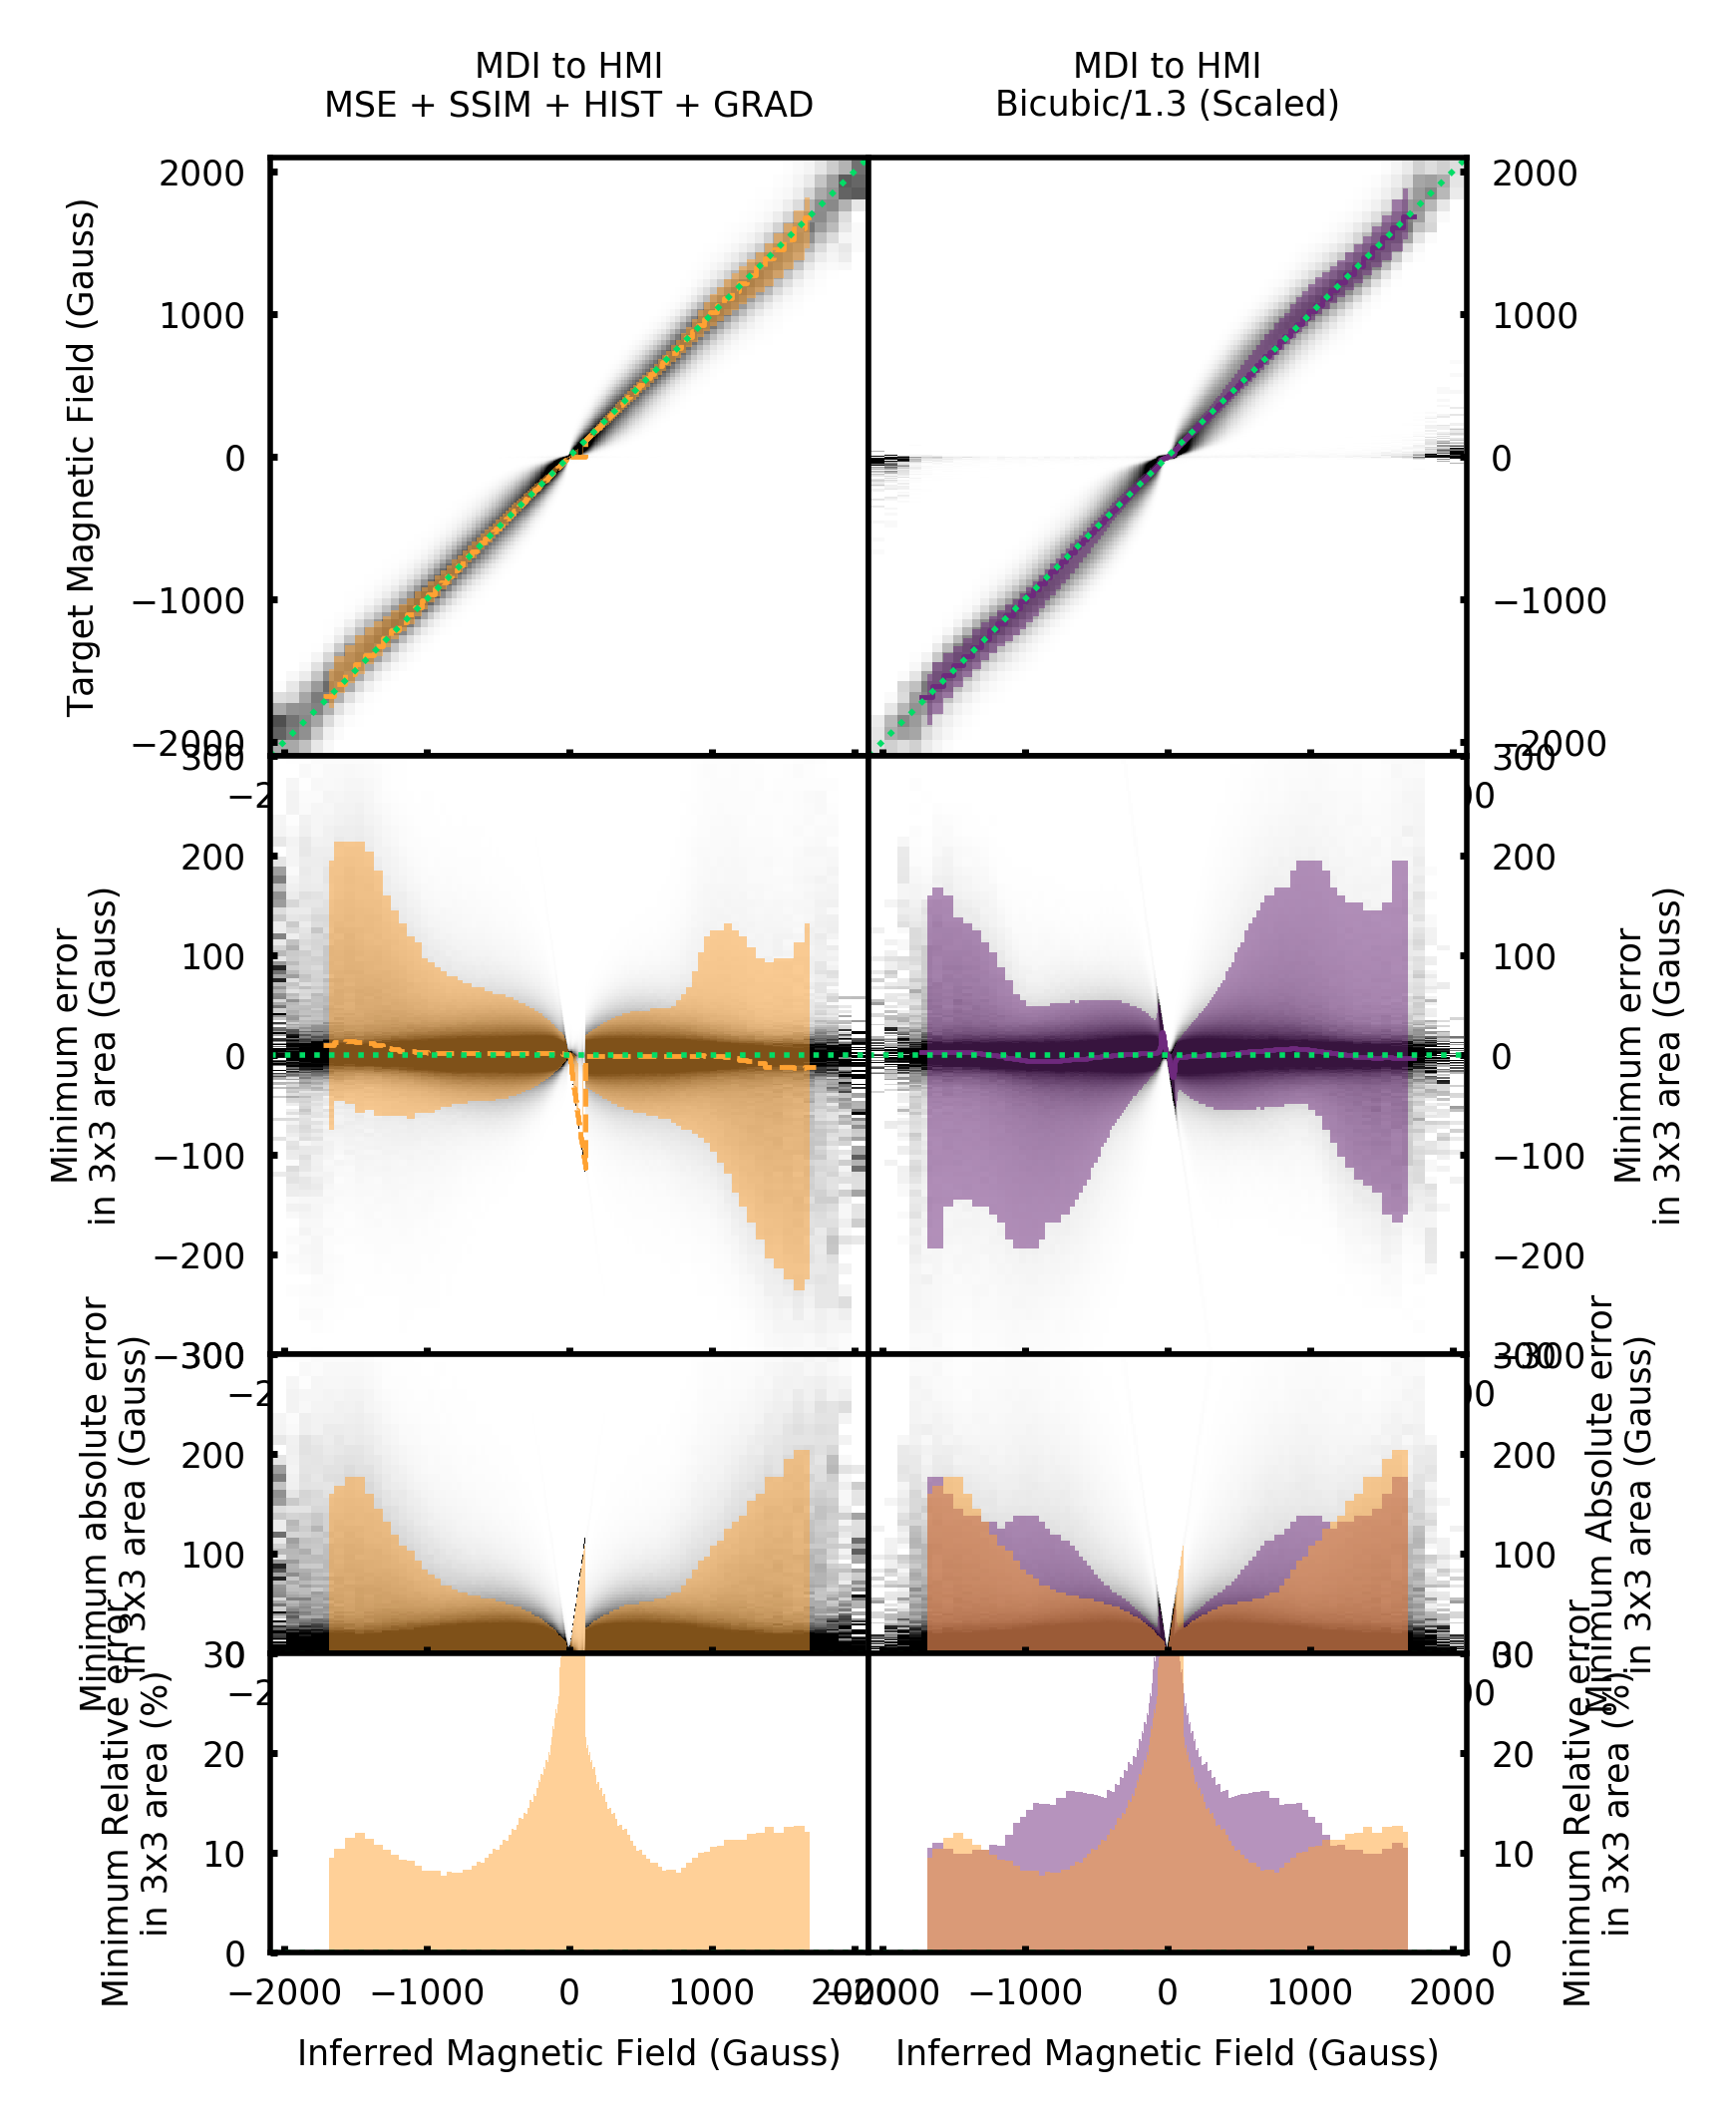

In [17]:
limit_field=1700

ftsz = 4

cmax = 700

ax_lim = 2100
ax_lim_er = 300

p1 = 0.05
p2 = 0.95

res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

index = np.sum(cdf_to_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_to_ery<=p1,axis=0)
index[index==index.shape[0]] -= 1
per15 = centers[index]
per15[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_to_ery<=p2,axis=0)
index[index==index.shape[0]] -= 1
per85 = centers[index]
per85[np.abs(centers)>limit_field] = np.nan


# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx/2, ppxy/2])

ax1.pcolormesh(bins,bins,norm_toy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)
ax1.plot(centers, centers+median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax1.fill_between(centers/Cal, centers+per15, centers+per85, fc='#ffa232', alpha=0.5, ec='None', step='mid')




# ax1.legend(frameon=False, fontsize=5)
ax1.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax1.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax1.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
ax1.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax1.set_xlim([-ax_lim, ax_lim])
ax1.set_ylim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')






Cal = 1.3
Cal = 0.67

Cal=1
# Cal=1.90

index = np.sum(cdf_ti_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan


index = np.sum(cdf_ti_ery<=p1,axis=0)
index[index==index.shape[0]] -= 1
per15 = centers[index]
per15[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_ti_ery<=p2,axis=0)
index[index==index.shape[0]] -= 1
per85 = centers[index]
per85[np.abs(centers)>limit_field] = np.nan

ax2 = fig.add_axes([ppadh+ppxx/2, ppadv, ppxx/2, ppxy/2])

ax2.pcolormesh(bins/Cal,bins,norm_tiy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

ax2.plot(centers/Cal,centers/Cal+median/Cal, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2.fill_between(centers/Cal, centers/Cal+per15/Cal, centers/Cal+per85/Cal, fc=Clr[2], alpha=0.5, ec='None', step='mid')

ax2.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax2.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
ax2.set_xlim([-ax_lim, ax_lim])
ax2.set_ylim([-ax_lim, ax_lim])
# ax2.xaxis.set_ticks_position('top')



print(np.nanmean((centers+median)/centers))



index = np.sum(cdf_to_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_to_ery<=p1,axis=0)
index[index==index.shape[0]] -= 1
per15 = centers[index]
per15[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_to_ery<=p2,axis=0)
index[index==index.shape[0]] -= 1
per85 = centers[index]
per85[np.abs(centers)>limit_field] = np.nan


# Inferred
ax3 = fig.add_axes([ppadh, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax3.pcolormesh(bins,bins,norm_to_ery, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

ax3.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax3.fill_between(centers/Cal, per15, per85, fc='#ffa232', alpha=0.5, ec='None', step='mid')


ax3.set_ylabel('Minimum error\nin 3x3 area (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax3.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax3.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax3.set_ylim([-ax_lim_er, ax_lim_er])
ax3.set_xlim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')


Cal=1

index = np.sum(cdf_ti_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan


index = np.sum(cdf_ti_ery<=p1,axis=0)
index[index==index.shape[0]] -= 1
per15 = centers[index]
per15[np.abs(centers)>limit_field] = np.nan

index = np.sum(cdf_ti_ery<=p2,axis=0)
index[index==index.shape[0]] -= 1
per85 = centers[index]
per85[np.abs(centers)>limit_field] = np.nan


ax4 = fig.add_axes([ppadh+ppxx/2, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax4.pcolormesh(bins/Cal,bins,norm_ti_ery, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

ax4.plot(centers/Cal,median, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax4.fill_between(centers/Cal, per15, per85, fc=Clr[2], alpha=0.5, ec='None', step='mid')


ax4.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax4.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
# ax4.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
ax4.set_xlim([-ax_lim, ax_lim])
ax4.set_ylim([-ax_lim_er, ax_lim_er])
# ax2.xaxis.set_ticks_position('top')
ax4.set_ylabel('Minimum error\nin 3x3 area (Gauss)', fontsize=5)




index = np.sum(cdf_to_er_absy<=0.9,axis=0)
index[index==centers_abs.shape[0]] -= 1
per85 = centers_abs[index]
per85[np.abs(centers)>limit_field] = np.nan

per85ml = per85.copy()

# Inferred
ax5 = fig.add_axes([ppadh, ppadv-ppxy/2-ppxy/4, ppxx/2, ppxy/4])

ax5.pcolormesh(bins,bins_abs,norm_to_er_absy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# ax5.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax5.fill_between(centers/Cal, per85*0, per85, fc='#ffa232', alpha=0.5, ec='None', step='mid')


ax5.set_ylabel('Minimum absolute error\nin 3x3 area (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax5.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax5.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax5.set_ylim([0, ax_lim_er])
ax5.set_xlim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')






index = np.sum(cdf_ti_er_absy<=0.9,axis=0)
index[index==centers_abs.shape[0]] -= 1
per85 = centers_abs[index]
per85[np.abs(centers)>limit_field] = np.nan


# Inferred
ax6 = fig.add_axes([ppadh+ppxx/2, ppadv-ppxy/2-ppxy/4, ppxx/2, ppxy/4])

ax6.pcolormesh(bins,bins_abs,norm_ti_er_absy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# ax5.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax6.fill_between(centers/Cal, per85*0, per85, fc=Clr[2], alpha=0.5, ec='None', step='mid')
ax6.fill_between(centers/Cal, per85ml*0, per85ml, fc='#ffa232', alpha=0.5, ec='None', step='mid')


ax6.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax6.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax6.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax6.set_ylim([0, ax_lim_er])
ax6.set_xlim([-ax_lim, ax_lim])
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_ylabel('Minimum Absolute error\nin 3x3 area (Gauss)', fontsize=5)

# ax1.xaxis.set_ticks_position('top')



index = np.sum(cdf_to_er_absy<=0.9,axis=0)
index[index==centers_abs.shape[0]] -= 1
per85 = centers_abs[index]
per85[np.abs(centers)>limit_field] = np.nan

per85ml = per85.copy()

# Inferred
ax7 = fig.add_axes([ppadh, ppadv-ppxy/2-2*ppxy/4, ppxx/2, ppxy/4])

# ax7.pcolormesh(bins,bins_abs,norm_to_er_absy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# ax5.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax7.fill_between(centers/Cal, per85*0, per85*Cal/np.abs(centers)*100, fc='#ffa232', alpha=0.5, ec='None', step='mid')


ax7.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
ax7.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax7.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax7.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax7.set_ylim([0, 30])
ax7.set_xlim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')
ax7.set_ylabel('Minimum Relative error\nin 3x3 area (%)', fontsize=5)



index = np.sum(cdf_ti_er_absy<=0.9,axis=0)
index[index==centers_abs.shape[0]] -= 1
per85 = centers_abs[index]
per85[np.abs(centers)>limit_field] = np.nan


# Inferred
ax8 = fig.add_axes([ppadh+ppxx/2, ppadv-ppxy/2-2*ppxy/4, ppxx/2, ppxy/4])

# ax8.pcolormesh(bins,bins_abs,norm_ti_er_absy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.01)

# ax5.plot(centers,median, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
ax8.fill_between(centers/Cal, per85*0, per85*Cal/np.abs(centers)*100, fc=Clr[2], alpha=0.5, ec='None', step='mid')
ax8.fill_between(centers/Cal, per85ml*0, per85ml*Cal/np.abs(centers)*100, fc='#ffa232', alpha=0.5, ec='None', step='mid')


# ax8.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
ax8.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax8.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax8.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax3.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax8.set_ylim([0, 30])
ax8.set_xlim([-ax_lim, ax_lim])
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
ax8.set_ylabel('Minimum Relative error\nin 3x3 area (%)', fontsize=5)





# fig.savefig(label + '_scatter_percentiles.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

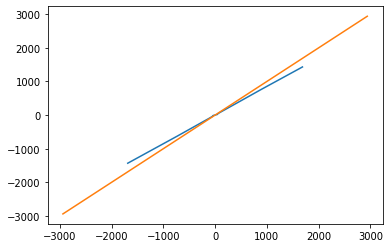

In [18]:
index = np.sum(cdf_ti_ery<=0.5,axis=0)
index[index==index.shape[0]] -= 1
median = centers[index]
median[np.abs(centers)>limit_field] = np.nan


plt.plot(centers, (centers+median)*0.85)
plt.plot(centers, centers)

In [19]:
np.nansum(np.abs((centers-(centers+median)*.8)))

15101.539999999997

In [20]:
np.nansum(np.abs(centers/(centers+median))*widths)/np.nansum(widths)

0.5897060553289205

In [21]:
x = (centers/(centers+median)).copy()
y = widths.copy()

y = y[np.isfinite(x)]
x = x[np.isfinite(x)]

np.sum(x*y)/np.sum(y)

1.0273779849799454

In [22]:
np.sum((widths)/np.sum(widths))

1.0

In [23]:
zero_in = (centers==0).nonzero()[0][0]

abs_to_er = hist2_to_er[:,zero_in:].copy()
neg_to_er = np.flipud(hist2_to_er[:,0:zero_in].copy())

abs_to_er[:,1:] += neg_to_er


In [24]:
centers[0:zero_in]

array([-2.942190e+03, -2.809330e+03, -2.682450e+03, -2.561280e+03,
       -2.445560e+03, -2.335050e+03, -2.229515e+03, -2.128730e+03,
       -2.032480e+03, -1.940560e+03, -1.852780e+03, -1.768950e+03,
       -1.688895e+03, -1.612440e+03, -1.539425e+03, -1.469700e+03,
       -1.403110e+03, -1.339520e+03, -1.278795e+03, -1.220795e+03,
       -1.165405e+03, -1.112515e+03, -1.062005e+03, -1.013765e+03,
       -9.676950e+02, -9.237000e+02, -8.816850e+02, -8.415600e+02,
       -8.032450e+02, -7.666550e+02, -7.317100e+02, -6.983350e+02,
       -6.664600e+02, -6.360250e+02, -6.069600e+02, -5.792000e+02,
       -5.526900e+02, -5.273750e+02, -5.032000e+02, -4.801100e+02,
       -4.580600e+02, -4.370050e+02, -4.168950e+02, -3.976900e+02,
       -3.793500e+02, -3.618350e+02, -3.451100e+02, -3.291350e+02,
       -3.138800e+02, -2.993150e+02, -2.854000e+02, -2.721100e+02,
       -2.594250e+02, -2.473100e+02, -2.357350e+02, -2.246850e+02,
       -2.141350e+02, -2.040550e+02, -1.944300e+02, -1.852400e

In [25]:
centers[zero_in+1:]

array([4.350000e-01, 9.150000e-01, 1.420000e+00, 1.950000e+00,
       2.505000e+00, 3.085000e+00, 3.690000e+00, 4.325000e+00,
       4.995000e+00, 5.695000e+00, 6.425000e+00, 7.190000e+00,
       7.990000e+00, 8.825000e+00, 9.700000e+00, 1.062000e+01,
       1.158500e+01, 1.259500e+01, 1.365000e+01, 1.475500e+01,
       1.591000e+01, 1.712000e+01, 1.839000e+01, 1.972000e+01,
       2.111000e+01, 2.256500e+01, 2.409000e+01, 2.569000e+01,
       2.736500e+01, 2.911500e+01, 3.095000e+01, 3.287000e+01,
       3.488000e+01, 3.698500e+01, 3.919000e+01, 4.150000e+01,
       4.391500e+01, 4.644500e+01, 4.910000e+01, 5.188000e+01,
       5.478500e+01, 5.782500e+01, 6.101000e+01, 6.435000e+01,
       6.784500e+01, 7.150500e+01, 7.534000e+01, 7.935000e+01,
       8.355000e+01, 8.795000e+01, 9.255500e+01, 9.738000e+01,
       1.024350e+02, 1.077250e+02, 1.132600e+02, 1.190600e+02,
       1.251350e+02, 1.314900e+02, 1.381500e+02, 1.451250e+02,
       1.524250e+02, 1.600700e+02, 1.680750e+02, 1.7646

In [26]:
# blob = bucket.blob('inference/' + run + '/histogram_target_output_d_' + suffix +'.npy')
# file = blob.download_to_filename('/tmp/histogram_target_output_d_' + suffix +'.npy')
# hist2_to = np.load('/tmp/histogram_target_output_d_' + suffix +'.npy')
# # hist2_to = np.transpose(hist2_to)


# blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
# file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
# hist2_ti = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
# # hist2_ti = np.transpose(hist2_ti)

In [27]:
bins = create_hist_bins()
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

# noise = 5

# hist2_to[np.abs(centers)<noise, :] = 0
# hist2_to[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0


min_no_samples = 20

hist2_to[hist2_to<min_no_samples] = 0
hist2_ti[hist2_ti<min_no_samples] = 0
# bins

In [28]:
binsp = np.linspace(0,1,bins.shape[0])
widthsp = (binsp[1:]-binsp[0:-1])
centersp = (binsp[1:]+binsp[0:-1])/2

x, y = np.meshgrid(widths,widths)

xp, yp = np.meshgrid(widthsp,widthsp)

In [29]:
y

array([[135.92, 135.92, 135.92, ..., 135.92, 135.92, 135.92],
       [129.8 , 129.8 , 129.8 , ..., 129.8 , 129.8 , 129.8 ],
       [123.96, 123.96, 123.96, ..., 123.96, 123.96, 123.96],
       ...,
       [123.96, 123.96, 123.96, ..., 123.96, 123.96, 123.96],
       [129.8 , 129.8 , 129.8 , ..., 129.8 , 129.8 , 129.8 ],
       [135.92, 135.92, 135.92, ..., 135.92, 135.92, 135.92]])

# Super-res histograms

In [30]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_SR_' + suffix +'.npy')
hist2_to_load = np.load('/tmp/histogram_target_output_SR_' + suffix +'.npy')
# hist2_to_load[hist2_to_load<min_no_samples] = 0

hist2_to_me = np.transpose(hist2_to_load[:,:])

blob = bucket.blob('inference/' + run + '/histogram_target_input_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_SR_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_SR_' + suffix +'.npy')
# hist2_ti_load[hist2_ti_load<min_no_samples] = 0

hist2_ti_me = np.transpose(hist2_ti_load[:,:])

In [31]:
norm_to_me=hist2_to_me/(x*y)/np.sum(hist2_to_me)
norm_ti_me=hist2_ti_me/(x*y)/np.sum(hist2_ti_me)

In [32]:
norm = np.sum(hist2_to_me, axis=0)[None, :]
norm[norm==0] = 1
norm_toy_me = hist2_to_me/x/np.repeat(norm, norm_to_me.shape[0], axis=0)

norm = np.sum(hist2_ti_me, axis=0)[None, :]
norm[norm==0] = 1
norm_tiy_me = hist2_ti_me/x/np.repeat(norm, norm_ti_me.shape[0], axis=0)

In [33]:
np.repeat(centers[:,None],norm_to.shape[0],axis=1) 

array([[-2942.19, -2942.19, -2942.19, ..., -2942.19, -2942.19, -2942.19],
       [-2809.33, -2809.33, -2809.33, ..., -2809.33, -2809.33, -2809.33],
       [-2682.45, -2682.45, -2682.45, ..., -2682.45, -2682.45, -2682.45],
       ...,
       [ 2682.45,  2682.45,  2682.45, ...,  2682.45,  2682.45,  2682.45],
       [ 2809.33,  2809.33,  2809.33, ...,  2809.33,  2809.33,  2809.33],
       [ 2942.19,  2942.19,  2942.19, ...,  2942.19,  2942.19,  2942.19]])

(0, 50)

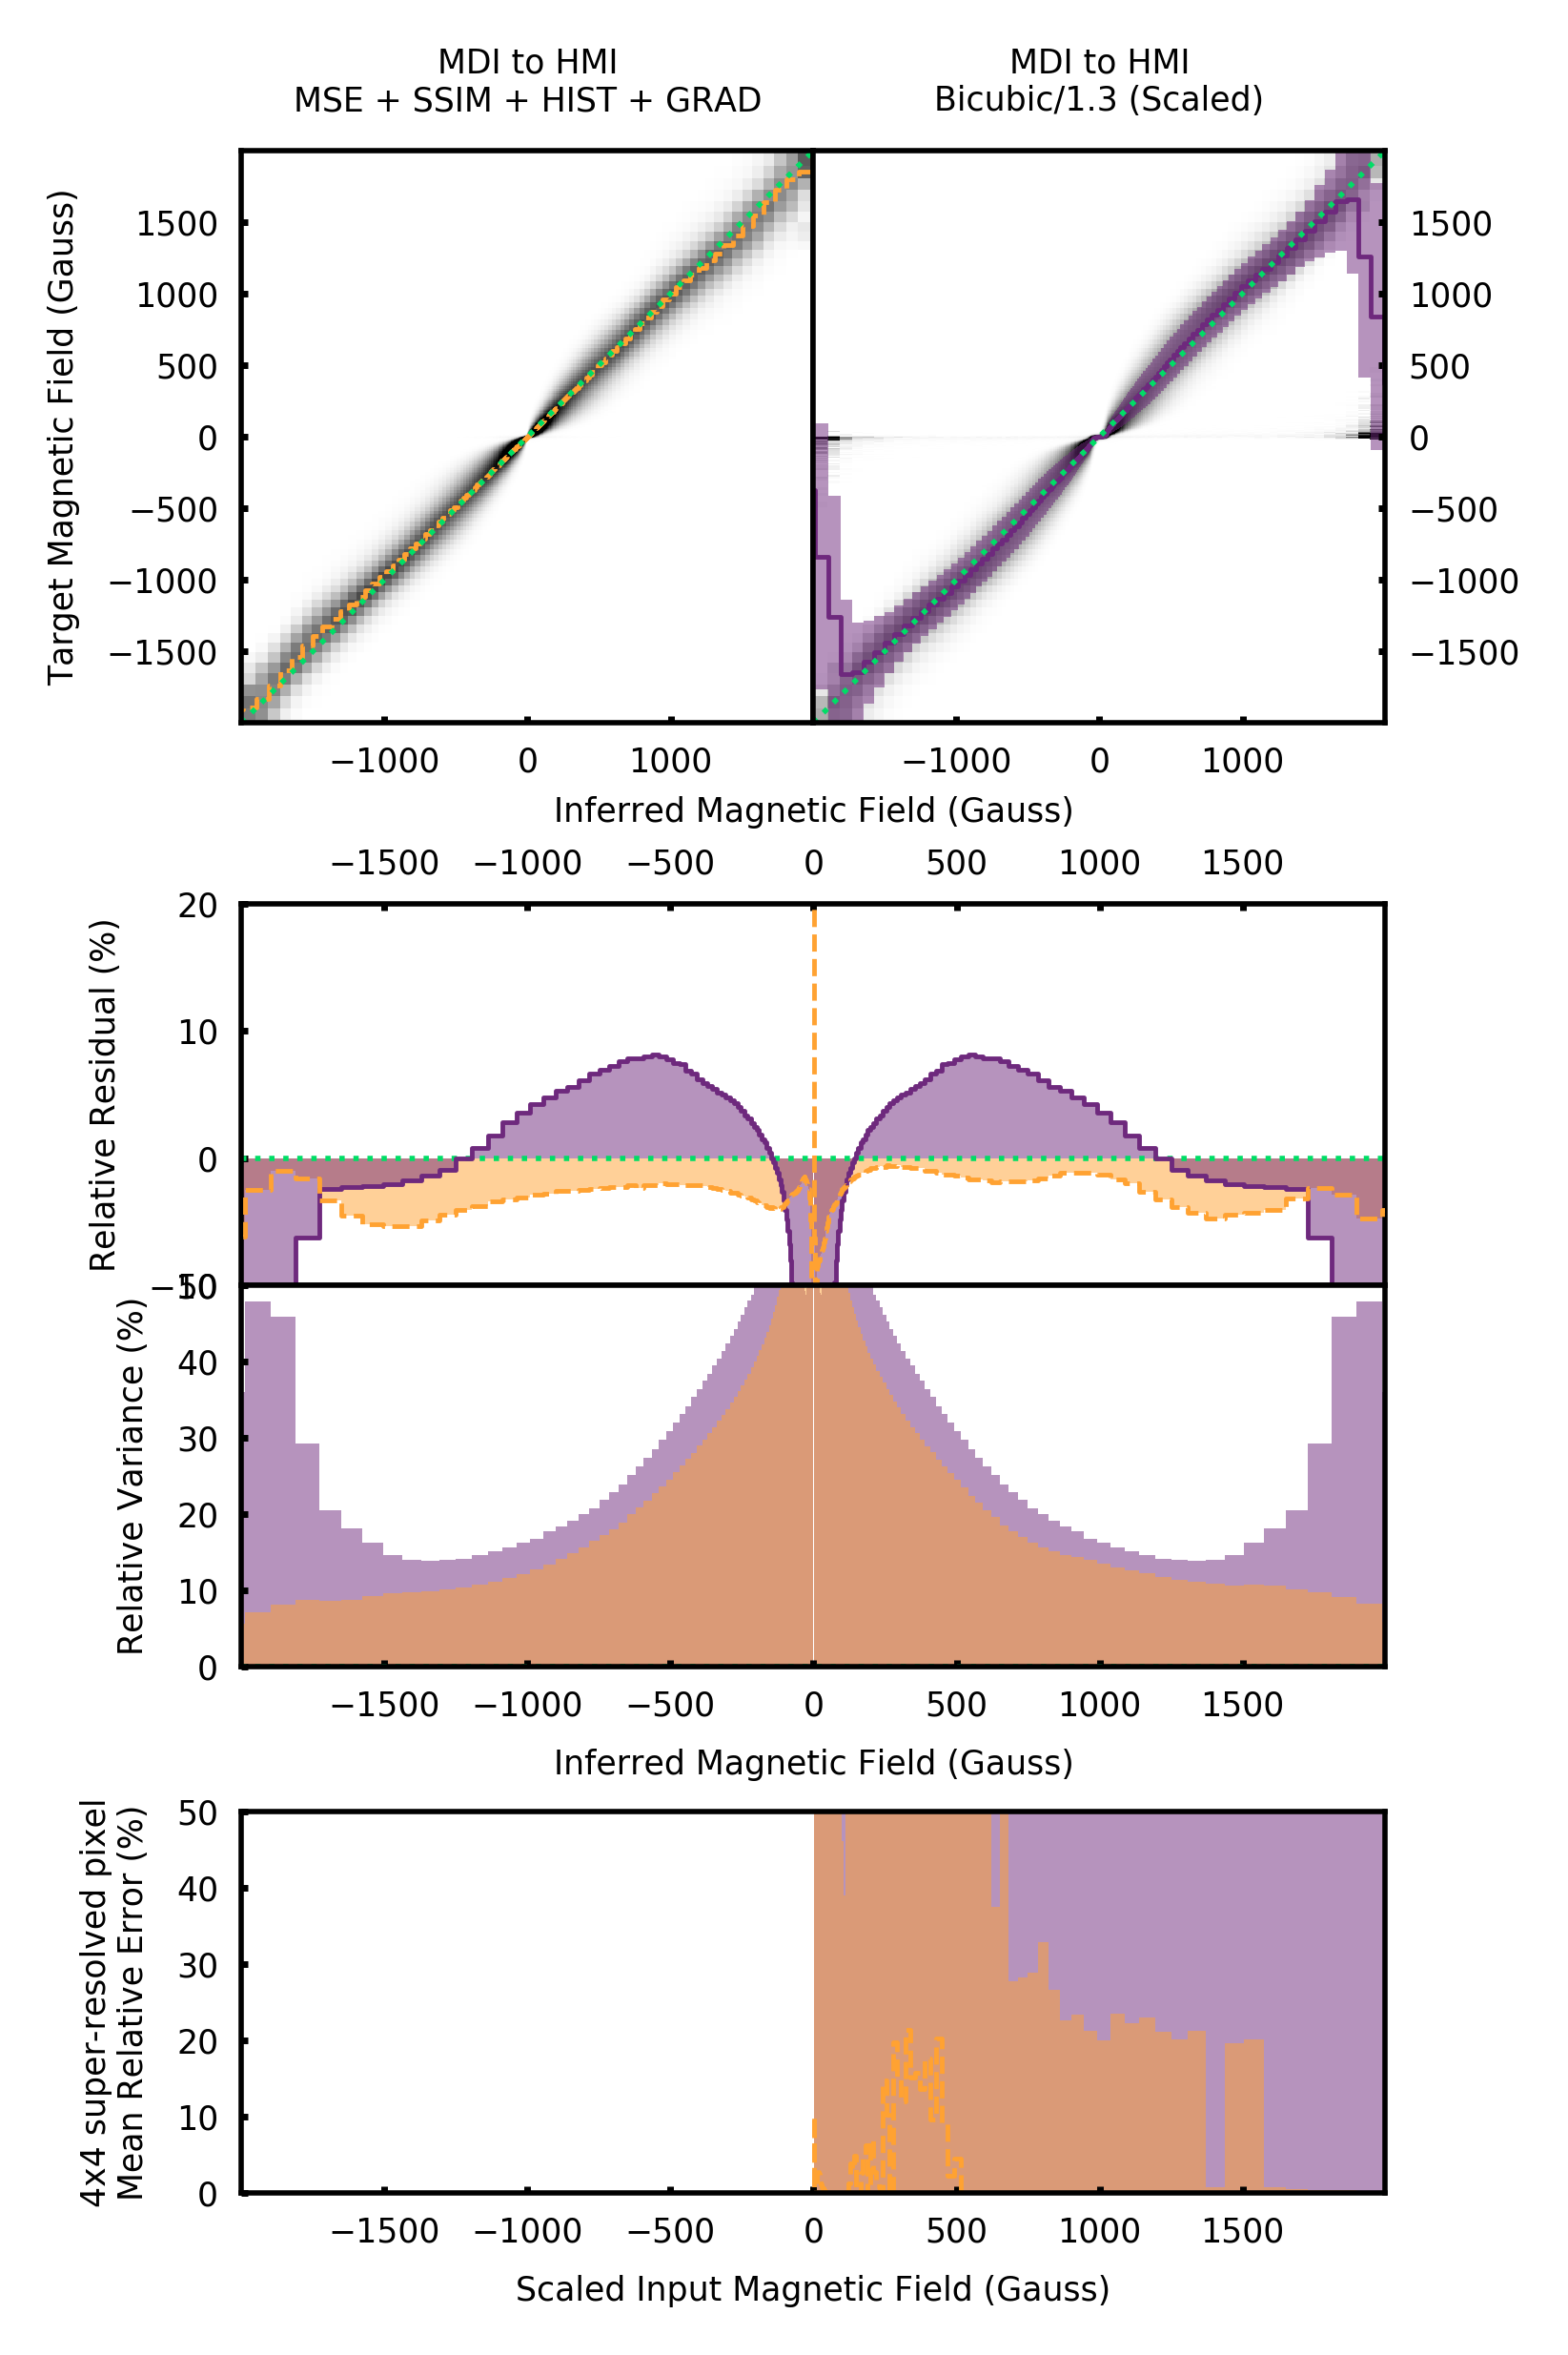

In [34]:
ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Inferred
ax1 = fig.add_axes([ppadh, ppadv, ppxx/2, ppxy/2])

ax1.pcolor(bins,bins,norm_toy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

# # expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
# # ax1.plot(expected, centers,linestyle='-', label=label, color='#ffa232', linewidth=0.5)
# expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
# expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan

x, y = np.meshgrid(widths,widths)
expected = np.nansum(norm_toy*y*np.repeat(centers[:,None],norm_to.shape[0],axis=1) , axis=0)

ax1.plot(centers,expected, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples

variance = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
variance = np.sqrt(variance)

# ax1.plot(centers,expected-variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax1.plot(centers,expected+variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

# ax1.fill_between(centers, expected-variance, expected+variance, fc='#ffa232', alpha=0.5, ec='None', step='mid')


# inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.5, axis=0).astype(int)
# median = centers[inx]
# median[inx==0] = np.nan
# # ax1.plot(centers, median)


# inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.1, axis=0).astype(int)
# p10 = centers[inx]
# p10[inx==0] = np.nan
# # ax1.plot(centers, p10)


# inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.9, axis=0).astype(int)
# p90 = centers[inx]
# p90[inx==0] = np.nan
# # ax1.plot(centers, p90)


# ax1.legend(frameon=False, fontsize=5)
ax1.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax1.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax1.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
ax1.set_title('MDI to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax1.set_xlim([-ax_lim, ax_lim])
ax1.set_ylim([-ax_lim, ax_lim])
# ax1.xaxis.set_ticks_position('top')



# Inferred residual
ax3 = fig.add_axes([ppadh, ppadv-ppxy/3-ppadv2, ppxx, ppxy/3])

expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
# ax3.plot(centers,(expected-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.7)
# Removing entries with few samples

varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
varianceML = np.sqrt(varianceML)

# ax3.plot(centers,(expected-variance-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax3.plot(centers,(expected+variance-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

# ax3.fill_between(centers, (expected-variance-centers)/np.abs(centers)*res_scale, (expected+variance-centers)/np.abs(centers)*res_scale, color='#ffa232', alpha=0.3, ec='None')

# ax3.plot(centers,variance/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
ax3.fill_between(centers,((expected-centers)/centers*res_scale), linestyle='--', label=label, fc='#ffa232', ec='None', alpha=0.5, step='mid')
ax3.plot(centers,((expected-centers)/centers*res_scale), linestyle='--', label=label, c='#ffa232', zorder=4, linewidth=0.7, ds= 'steps-mid')
# ax3.plot(centers,np.abs((expected-centers)), linestyle='--', label=label, color='#ffa232', linewidth=0.2)





# ax1.legend(frameon=False, fontsize=5)
ax3.set_ylabel('Relative Residual (%)', fontsize=5)
ax3.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax3.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax3.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
ax3.set_xlim([-ax_lim, ax_lim])
ax3.set_ylim([-10, res_lim])
# ax3.set_ylim([0, 200])
ax3.xaxis.set_ticks_position('top')
ax3.xaxis.set_label_position("top")



Cal = 1.3
Cal = 0.67

Cal=1
# Cal=1.90

ax2 = fig.add_axes([ppadh+ppxx/2, ppadv, ppxx/2, ppxy/2])

ax2.pcolor(bins/Cal,bins,norm_tiy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

# expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
# expected[np.nansum(hist2_ti, axis=1)<min_no_samples] = np.nan
ax2.plot(centers/Cal,expected, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
# Removing entries with few samples
# ax2.plot(centers,expected, linestyle='-', label=label, color='#ffa232', linewidth=1)

variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
variance = np.sqrt(variance)

# ax2.plot(centers/Cal,(expected-variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)
# ax2.plot(centers/Cal,(expected+variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)

ax2.fill_between(centers/Cal, (expected-variance), (expected+variance), fc=Clr[2], alpha=0.5, ec='None', step='mid')

inx = np.sum(np.cumsum(norm_tiy*x,axis=0)<0.5, axis=0).astype(int)
median = centers[inx]
median[inx==0] = np.nan
# ax2.plot(centers, median)


# ax2.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
# ax2.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax2.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax2.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
ax2.set_xlim([-ax_lim, ax_lim])
ax2.set_ylim([-ax_lim, ax_lim])
# ax2.xaxis.set_ticks_position('top')



ax4 = fig.add_axes([ppadh, ppadv-ppxy/3-ppadv2-ppxy/3, ppxx, ppxy/3])

expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
# ax4.plot(centers/Cal,(expected-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.5)

variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
variance = np.sqrt(variance)

# ax4.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax4.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

# ax4.fill_between(centers/Cal, ((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, ((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, color='#ffa232', alpha=0.3, ec='None')


# ax3.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
# ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)

# ax3.plot(centers/Cal,variance/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
ax4.fill_between(centers/Cal,np.abs(variance/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
ax3.fill_between(centers/Cal,((expected-centers/Cal)/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
ax3.plot(centers/Cal,((expected-centers/Cal)/centers/Cal*res_scale), label=label, c=Clr[2], linewidth=0.7, ds= 'steps-mid')
# ax3.plot(centers/Cal,np.abs((expected-centers)), linestyle='--', label=label, color='b', linewidth=0.2)
# ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
ax4.fill_between(centers/Cal,np.abs(varianceML/centers*res_scale), label=label, fc='#ffa232', ec='None', alpha=0.5, step='mid')
# ax4.plot(centers/Cal,np.abs(variance), linestyle='-', label=label, color='b', linewidth=0.2)
# ax4.plot(centers,np.abs(varianceML), linestyle='-', label=label, color='#ffa232', linewidth=0.2)


ax4.set_ylabel('Relative Variance (%)', fontsize=5)
ax4.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax4.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax4.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.plot([-15, -15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.plot([15, 15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.yaxis.tick_right()
# ax4.yaxis.set_label_position("right")
ax4.set_xlim([-ax_lim, ax_lim])
ax4.set_ylim([0, 50])
# ax4.set_ylim([0, 200])









buff_prp = 0.97

######################################################################################################


Cal = 1
# Cal = 1.90

# Inferred
ax5 = fig.add_axes([ppadh, ppadv-ppxy/3-1.8*ppadv2-ppxy/3-ppxy/3, ppxx, ppxy/3])

# ax5.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

expected = np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)
ax5.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')

variance = np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti_me.shape[0],axis=1) - np.repeat(expected[None],norm_ti_me.shape[0],axis=0))**2*norm_ti_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)
variance = np.sqrt(variance)
ax5.fill_between(centers/Cal, (expected-variance)/np.abs(centers/Cal)*res_scale, (expected+variance)/np.abs(centers/Cal)*res_scale, fc=Clr[2], alpha=0.5, ec='None', step='mid')



# ax5.pcolor(bins,bins, norm_toy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_toy_me)*0.01)

expected = np.nansum(np.repeat(widths[:,None],norm_to_me.shape[0],axis=1)*np.repeat(centers[:,None],norm_to_me.shape[0],axis=1)*norm_to_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to_me.shape[0],axis=1)*norm_to_me, axis=0)
ax5.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')

variance = np.nansum(np.repeat(widths[:,None],norm_to_me.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to_me.shape[0],axis=1) - np.repeat(expected[None],norm_to_me.shape[0],axis=0))**2*norm_to_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to_me.shape[0],axis=1)*norm_to_me, axis=0)
variance = np.sqrt(variance)
ax5.fill_between(centers/Cal, (expected-variance)/np.abs(centers/Cal)*res_scale, (expected+variance)/np.abs(centers/Cal)*res_scale, fc='#ffa232', alpha=0.5, ec='None', step='mid')



# ax1.legend(frameon=False, fontsize=5)
ax5.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=5)
ax5.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=5)
ax5.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

# ax5.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax1.set_title(label, fontsize=5)
# ax1.set_title(label, fontsize=5)
# ax5.set_title('GONG to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
ax5.set_xlim([-ax_lim, ax_lim])
ax5.set_ylim([0, 50])
# ax1.xaxis.set_ticks_position('top')




######################################################################################################



# # Inferred
# ax6 = fig.add_axes([ppadh+ppxx/2 + ppxx/2*(1-buff_prp), ppadv-ppxy/3-1.8*ppadv2-ppxy/3-ppxy/3, ppxx/2*buff_prp, ppxy/3])

# # ax6.pcolor(bins,binsp, norm_tiy_pr, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_pr)*0.01)

# expected = np.nansum(np.repeat(widthsp[:,None],norm_ti_pr.shape[0],axis=1)*np.repeat(centersp[:,None],norm_ti_pr.shape[0],axis=1)*norm_ti_pr, axis=0)/np.nansum(np.repeat(widthsp[:,None],norm_ti_pr.shape[0],axis=1)*norm_ti_pr, axis=0)
# ax6.plot(centers,expected, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')

# variance = np.nansum(np.repeat(widthsp[:,None],norm_ti_pr.shape[0],axis=1)*(np.repeat(centersp[:,None],norm_ti_pr.shape[0],axis=1) - np.repeat(expected[None],norm_ti_pr.shape[0],axis=0))**2*norm_ti_pr, axis=0)/np.nansum(np.repeat(widthsp[:,None],norm_ti_pr.shape[0],axis=1)*norm_ti_pr, axis=0)
# variance = np.sqrt(variance)
# ax6.fill_between(centers, (expected-variance), (expected+variance), fc=Clr[2], alpha=0.5, ec='None', step='mid')



# # ax6.pcolor(bins,binsp, norm_toy_pr, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_toy_pr)*0.01)

# expected = np.nansum(np.repeat(widthsp[:,None],norm_to_pr.shape[0],axis=1)*np.repeat(centersp[:,None],norm_to_pr.shape[0],axis=1)*norm_to_pr, axis=0)/np.nansum(np.repeat(widthsp[:,None],norm_to_pr.shape[0],axis=1)*norm_to_pr, axis=0)
# ax6.plot(centers,expected, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')

# variance = np.nansum(np.repeat(widthsp[:,None],norm_to_pr.shape[0],axis=1)*(np.repeat(centersp[:,None],norm_to_pr.shape[0],axis=1) - np.repeat(expected[None],norm_to_pr.shape[0],axis=0))**2*norm_to_pr, axis=0)/np.nansum(np.repeat(widthsp[:,None],norm_to_pr.shape[0],axis=1)*norm_to_pr, axis=0)
# variance = np.sqrt(variance)
# ax6.fill_between(centers, (expected-variance), (expected+variance), fc='#ffa232', alpha=0.5, ec='None', step='mid')



# # ax1.legend(frameon=False, fontsize=5)
# ax6.set_ylabel('4x4 super-resolved pixel\nPearson Correlation', fontsize=5)
# ax6.set_xlabel('Input Magnetic Field (Gauss)', fontsize=5)
# ax6.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

# # ax5.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# # ax1.set_title(label, fontsize=5)
# # ax1.set_title(label, fontsize=5)
# # ax5.set_title('GONG to HMI\nMSE + SSIM + HIST + GRAD', fontsize=5)
# ax6.set_xlim([-ax_lim, ax_lim])
# ax6.set_ylim([0, 1])
# ax6.yaxis.set_ticks_position('right')
# ax6.yaxis.tick_right()
# ax6.yaxis.set_label_position("right")



# fig.savefig(label + '_scatter.png', bbox_inches='tight', dpi = dpi, pad_inches=0)

In [35]:
np.nanmedian(centers/expected)

5.054533030061237

In [36]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
hist2_to_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
hist2_to = hist2_to_load
# hist2_to = hist2_to_load[:,:,7]
hist2_to = np.sum(hist2_to_load, axis=2)

blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
hist2_ti = hist2_ti_load
# hist2_ti = hist2_ti_load[:,:,7]
hist2_ti = np.sum(hist2_ti_load, axis=2)

In [37]:
norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)

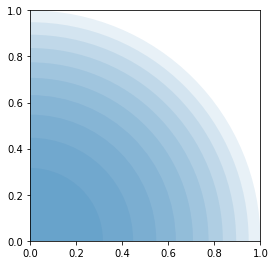

(11,)

In [38]:
nradii = 10
binsr = np.sqrt(np.arange(0,nradii+1)/nradii)

patches = []
for i in np.arange(1,nradii+1):
    circle = Circle((0, 0), binsr[i])
    patches.append(circle)

p = PatchCollection(patches, alpha=0.1)    

w, h = mpl.figure.figaspect(1.)
fig = plt.figure(figsize=(w, h))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])


ax.add_collection(p)

plt.show()

binsr.shape

0
1
2
3
4
5
6
7
8
9


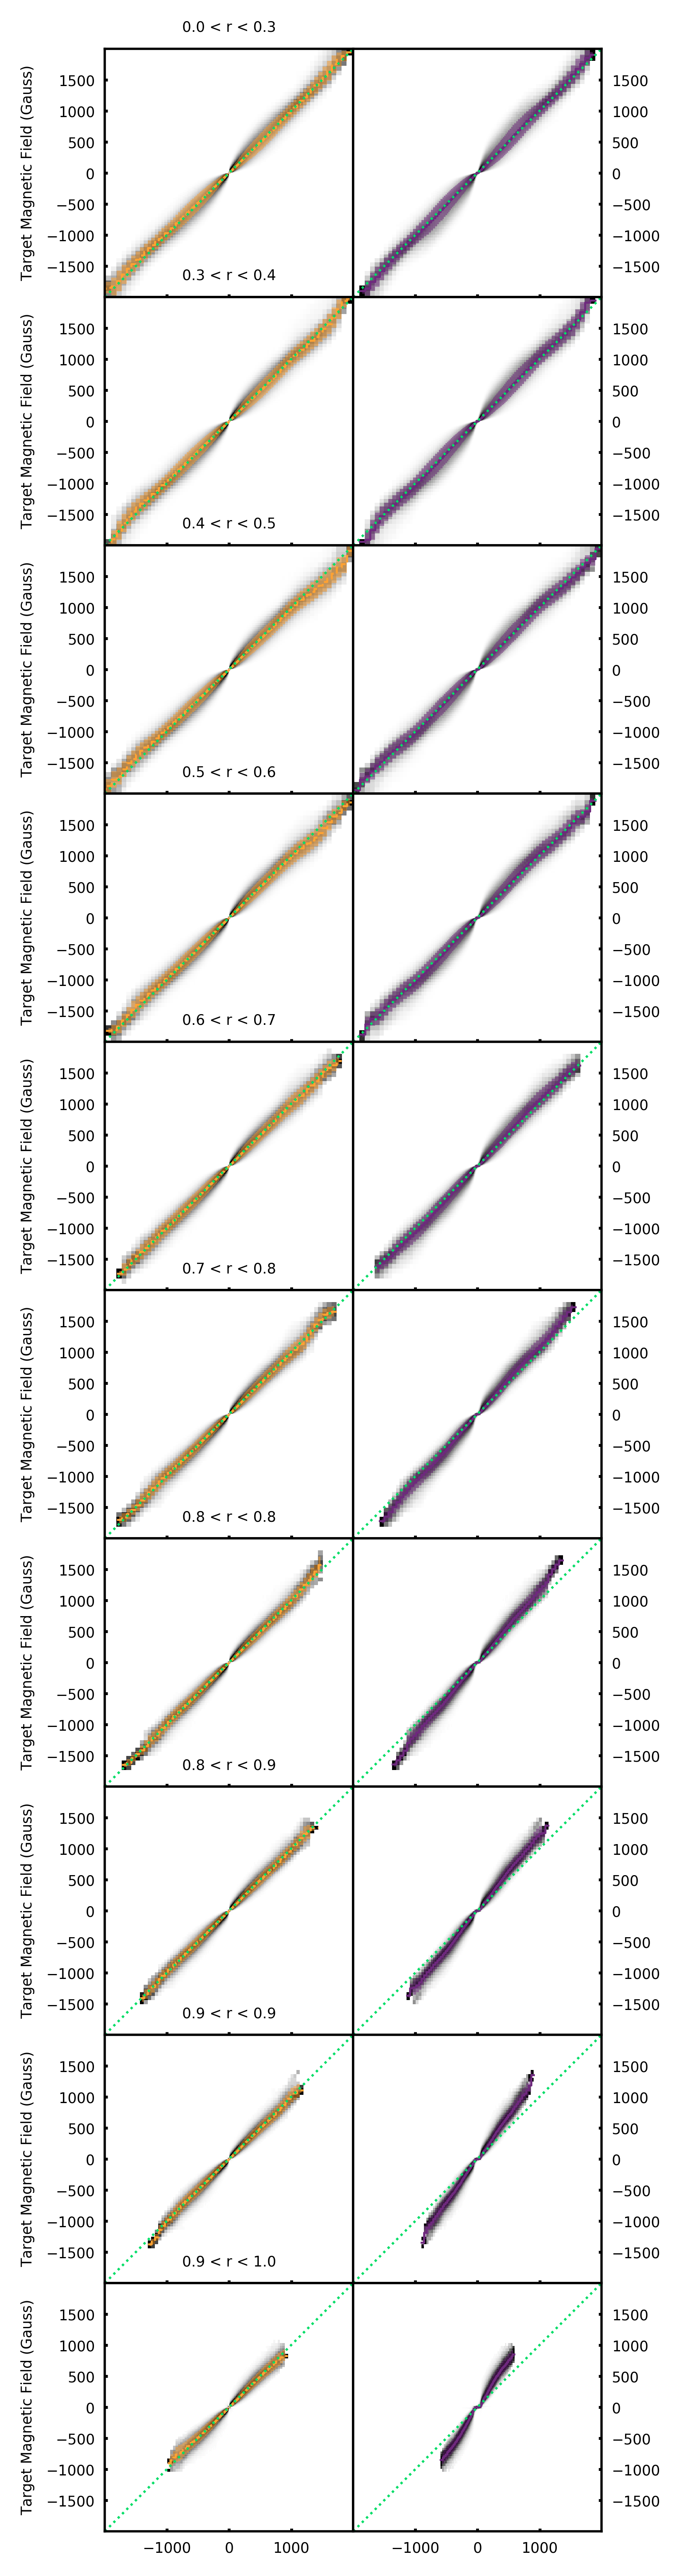

In [39]:

ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

for i in np.arange(0,10):
    print(i)
    
    blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to = hist2_to_load[:,:,i]

    blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti = hist2_ti_load[:,:,i]
    
    
    bins = create_hist_bins()
    centers = (bins[1:]+bins[0:-1])/2
    widths = (bins[1:]-bins[0:-1])

    noise = 5

    hist2_to[np.abs(centers)<noise, :] = 0
    hist2_to[:, np.abs(centers)<noise] = 0
    hist2_ti[np.abs(centers)<noise, :] = 0
    hist2_ti[:, np.abs(centers)<noise] = 0


    min_no_samples = 20

    hist2_to[hist2_to<min_no_samples] = 0
    hist2_ti[hist2_ti<min_no_samples] = 0
    
    norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
    norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

    norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
    norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)    
    
    
    # Inferred
    ax1 = fig.add_axes([ppadh, ppadv-ppxy/2*i, ppxx/2, ppxy/2])

    ax1.pcolor(bins,bins,norm_toy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

    # expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
    # ax1.plot(expected, centers,linestyle='-', label=label, color='#ffa232', linewidth=0.5)
    expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
    ax1.plot(centers,expected, linestyle='--', label=label, color='#ffa232', linewidth=0.7, ds= 'steps-mid')
    # Removing entries with few samples

    variance = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    variance = np.sqrt(variance)

    # ax1.plot(centers,expected-variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    # ax1.plot(centers,expected+variance, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

    ax1.fill_between(centers, expected-variance, expected+variance, fc='#ffa232', alpha=0.5, ec='None', step='mid')


    inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.5, axis=0).astype(int)
    median = centers[inx]
    median[inx==0] = np.nan
    # ax1.plot(centers, median)


    inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.1, axis=0).astype(int)
    p10 = centers[inx]
    p10[inx==0] = np.nan
    # ax1.plot(centers, p10)


    inx = np.sum(np.cumsum(norm_toy*x,axis=0)<0.9, axis=0).astype(int)
    p90 = centers[inx]
    p90[inx==0] = np.nan
    # ax1.plot(centers, p90)


    # ax1.legend(frameon=False, fontsize=5)
    ax1.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
    # ax1.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
    ax1.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

    ax1.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
    # ax1.set_title(label, fontsize=5)
    # ax1.set_title(label, fontsize=5)
    ax1.set_title(str(np.round(binsr[i],1)) + ' < r < ' + str(np.round(binsr[i+1],1)), fontsize=5)
    ax1.set_xlim([-ax_lim, ax_lim])
    ax1.set_ylim([-ax_lim, ax_lim])
    # ax1.xaxis.set_ticks_position('top')
    
    
    ax2 = fig.add_axes([ppadh+ppxx/2, ppadv-ppxy/2*i, ppxx/2, ppxy/2])

    ax2.pcolor(bins/Cal,bins,norm_tiy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

    # expected = np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*np.repeat(centers[None],norm_to.shape[0],axis=0)*norm_to, axis=1)/np.nansum(np.repeat(widths[None],norm_to.shape[0],axis=0)*norm_to, axis=1)
    expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    # expected[np.nansum(hist2_ti, axis=1)<min_no_samples] = np.nan
    ax2.plot(centers/Cal,expected, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
    # Removing entries with few samples
    # ax2.plot(centers,expected, linestyle='-', label=label, color='#ffa232', linewidth=1)

    variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    variance = np.sqrt(variance)

    # ax2.plot(centers/Cal,(expected-variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)
    # ax2.plot(centers/Cal,(expected+variance), linestyle='-', label=label, color=Clr[2], linewidth=0.2)

    ax2.fill_between(centers/Cal, (expected-variance), (expected+variance), fc=Clr[2], alpha=0.5, ec='None', step='mid')

    inx = np.sum(np.cumsum(norm_tiy*x,axis=0)<0.5, axis=0).astype(int)
    median = centers[inx]
    median[inx==0] = np.nan
    # ax2.plot(centers, median)


    # ax2.set_ylabel('Target Magnetic Field (Gauss)', fontsize=5)
    # ax2.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
    ax2.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

    ax2.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
#     ax2.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=5)
    ax2.set_xlim([-ax_lim, ax_lim])
    ax2.set_ylim([-ax_lim, ax_lim])
    # ax2.xaxis.set_ticks_position('top')

    


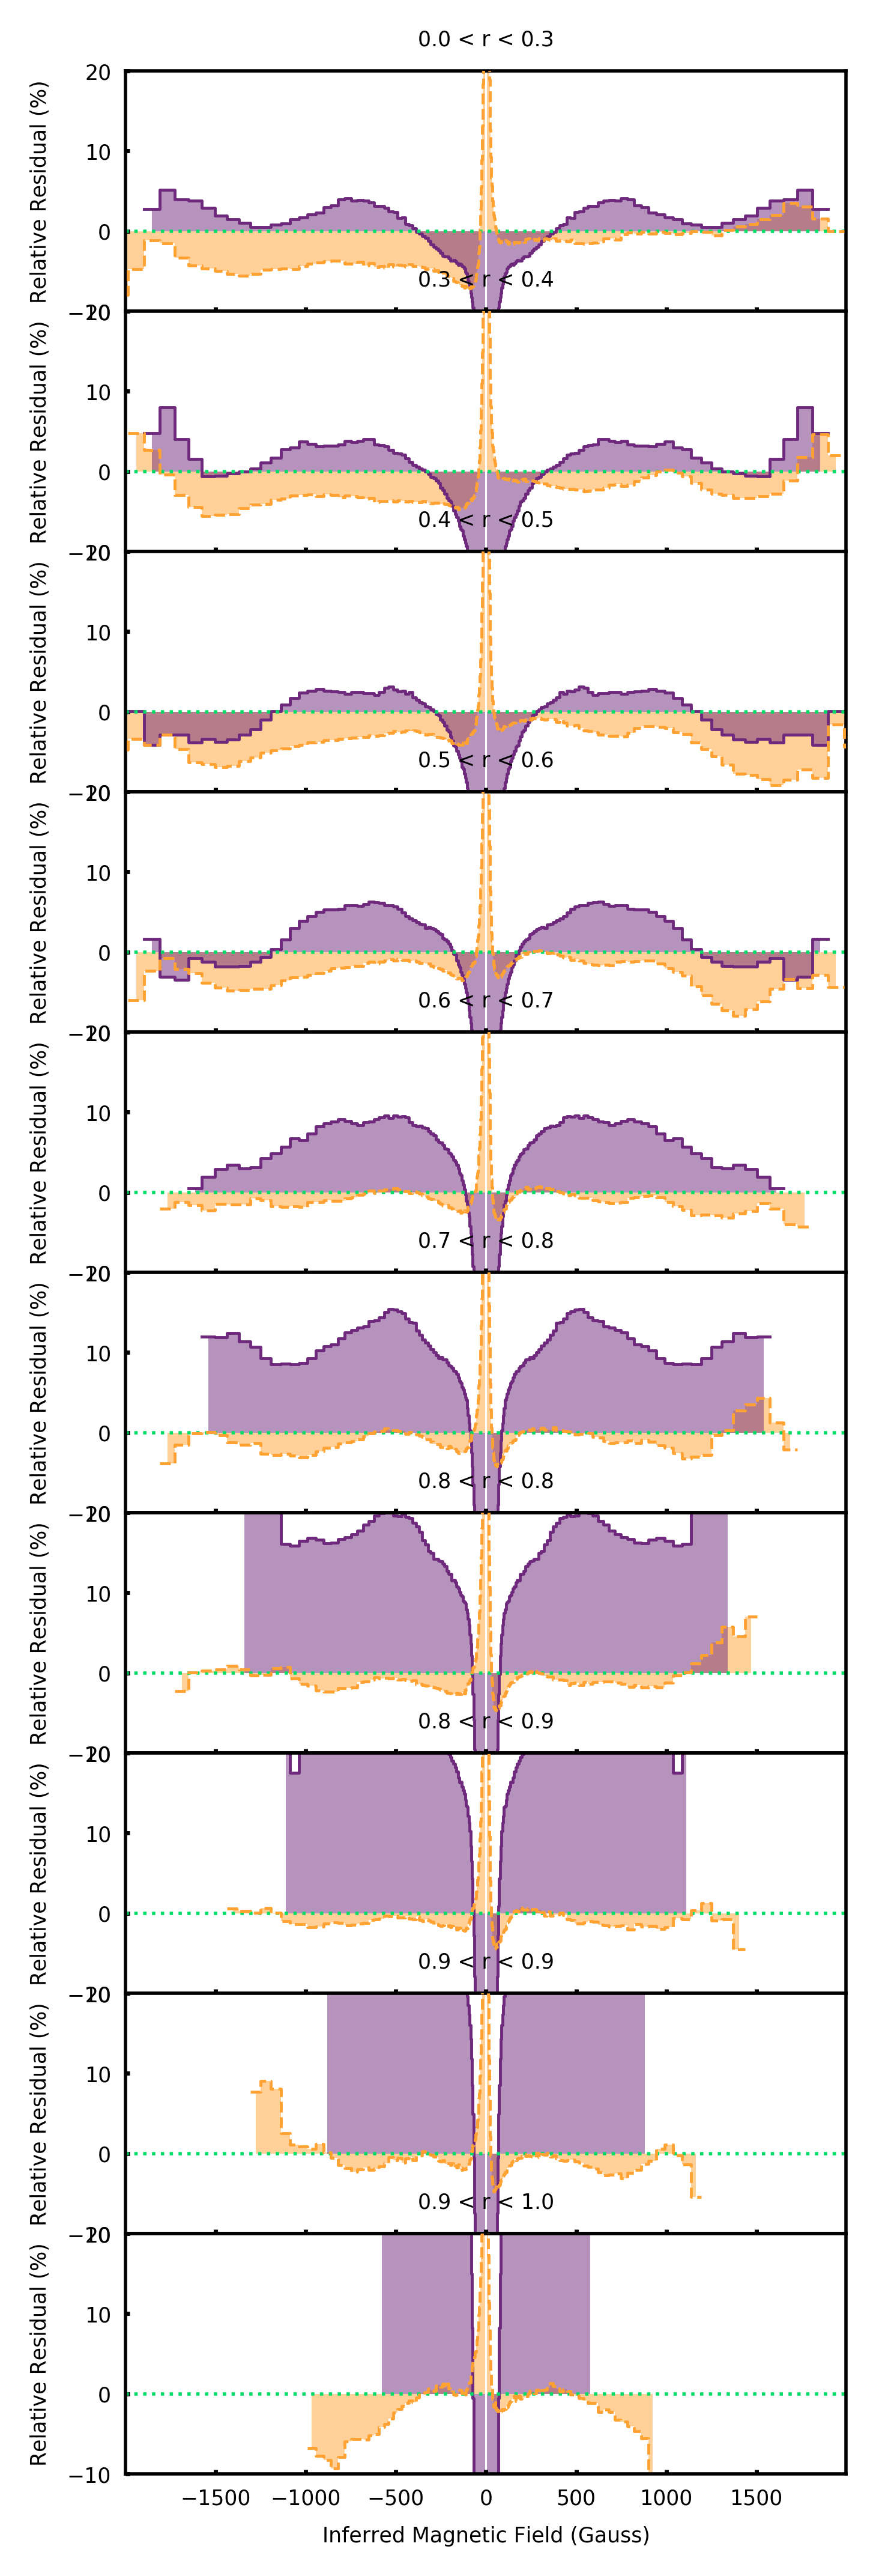

In [40]:


ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

for i in np.arange(0,10):
    
    blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to = hist2_to_load[:,:,i]

    blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti = hist2_ti_load[:,:,i]
    
    
    bins = create_hist_bins()
    centers = (bins[1:]+bins[0:-1])/2
    widths = (bins[1:]-bins[0:-1])

    noise = 5

    hist2_to[np.abs(centers)<noise, :] = 0
    hist2_to[:, np.abs(centers)<noise] = 0
    hist2_ti[np.abs(centers)<noise, :] = 0
    hist2_ti[:, np.abs(centers)<noise] = 0


    min_no_samples = 20

    hist2_to[hist2_to<min_no_samples] = 0
    hist2_ti[hist2_ti<min_no_samples] = 0
    
    norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
    norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

    norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
    norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)    
    
    
    # Inferred residual
    ax3 = fig.add_axes([ppadh, ppadv-ppxy/3*i, ppxx, ppxy/3])

    expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
    # ax3.plot(centers,(expected-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.7)
    # Removing entries with few samples

    varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    varianceML = np.sqrt(varianceML)

    # ax3.plot(centers,(expected-variance-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    # ax3.plot(centers,(expected+variance-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

    # ax3.fill_between(centers, (expected-variance-centers)/np.abs(centers)*res_scale, (expected+variance-centers)/np.abs(centers)*res_scale, color='#ffa232', alpha=0.3, ec='None')

    # ax3.plot(centers,variance/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    ax3.fill_between(centers,((expected-centers)/centers*res_scale), linestyle='--', label=label, fc='#ffa232', ec='None', alpha=0.5, step='mid')
    ax3.plot(centers,((expected-centers)/centers*res_scale), linestyle='--', label=label, c='#ffa232', zorder=4, linewidth=0.7, ds= 'steps-mid')
    # ax3.plot(centers,np.abs((expected-centers)), linestyle='--', label=label, color='#ffa232', linewidth=0.2)


    expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    # ax4.plot(centers/Cal,(expected-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.5)

    variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    variance = np.sqrt(variance)

    # ax4.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    # ax4.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

    # ax4.fill_between(centers/Cal, ((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, ((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, color='#ffa232', alpha=0.3, ec='None')


    # ax3.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    # ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)

    # ax3.plot(centers/Cal,variance/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    ax3.fill_between(centers/Cal,((expected-centers/Cal)/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
    ax3.plot(centers/Cal,((expected-centers/Cal)/centers/Cal*res_scale), label=label, c=Clr[2], linewidth=0.7, ds= 'steps-mid')


    # ax1.legend(frameon=False, fontsize=5)
    ax3.set_ylabel('Relative Residual (%)', fontsize=5)
    ax3.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
    ax3.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)
    ax3.set_title(str(np.round(binsr[i],1)) + ' < r < ' + str(np.round(binsr[i+1],1)), fontsize=5)

    ax3.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
    # ax1.set_title(label, fontsize=5)
    # ax1.set_title(label, fontsize=5)
    ax3.set_xlim([-ax_lim, ax_lim])
    ax3.set_ylim([-10, res_lim])
    # ax3.set_ylim([0, 200])
#     ax3.xaxis.set_ticks_position('top')
#     ax3.xaxis.set_label_position("top")

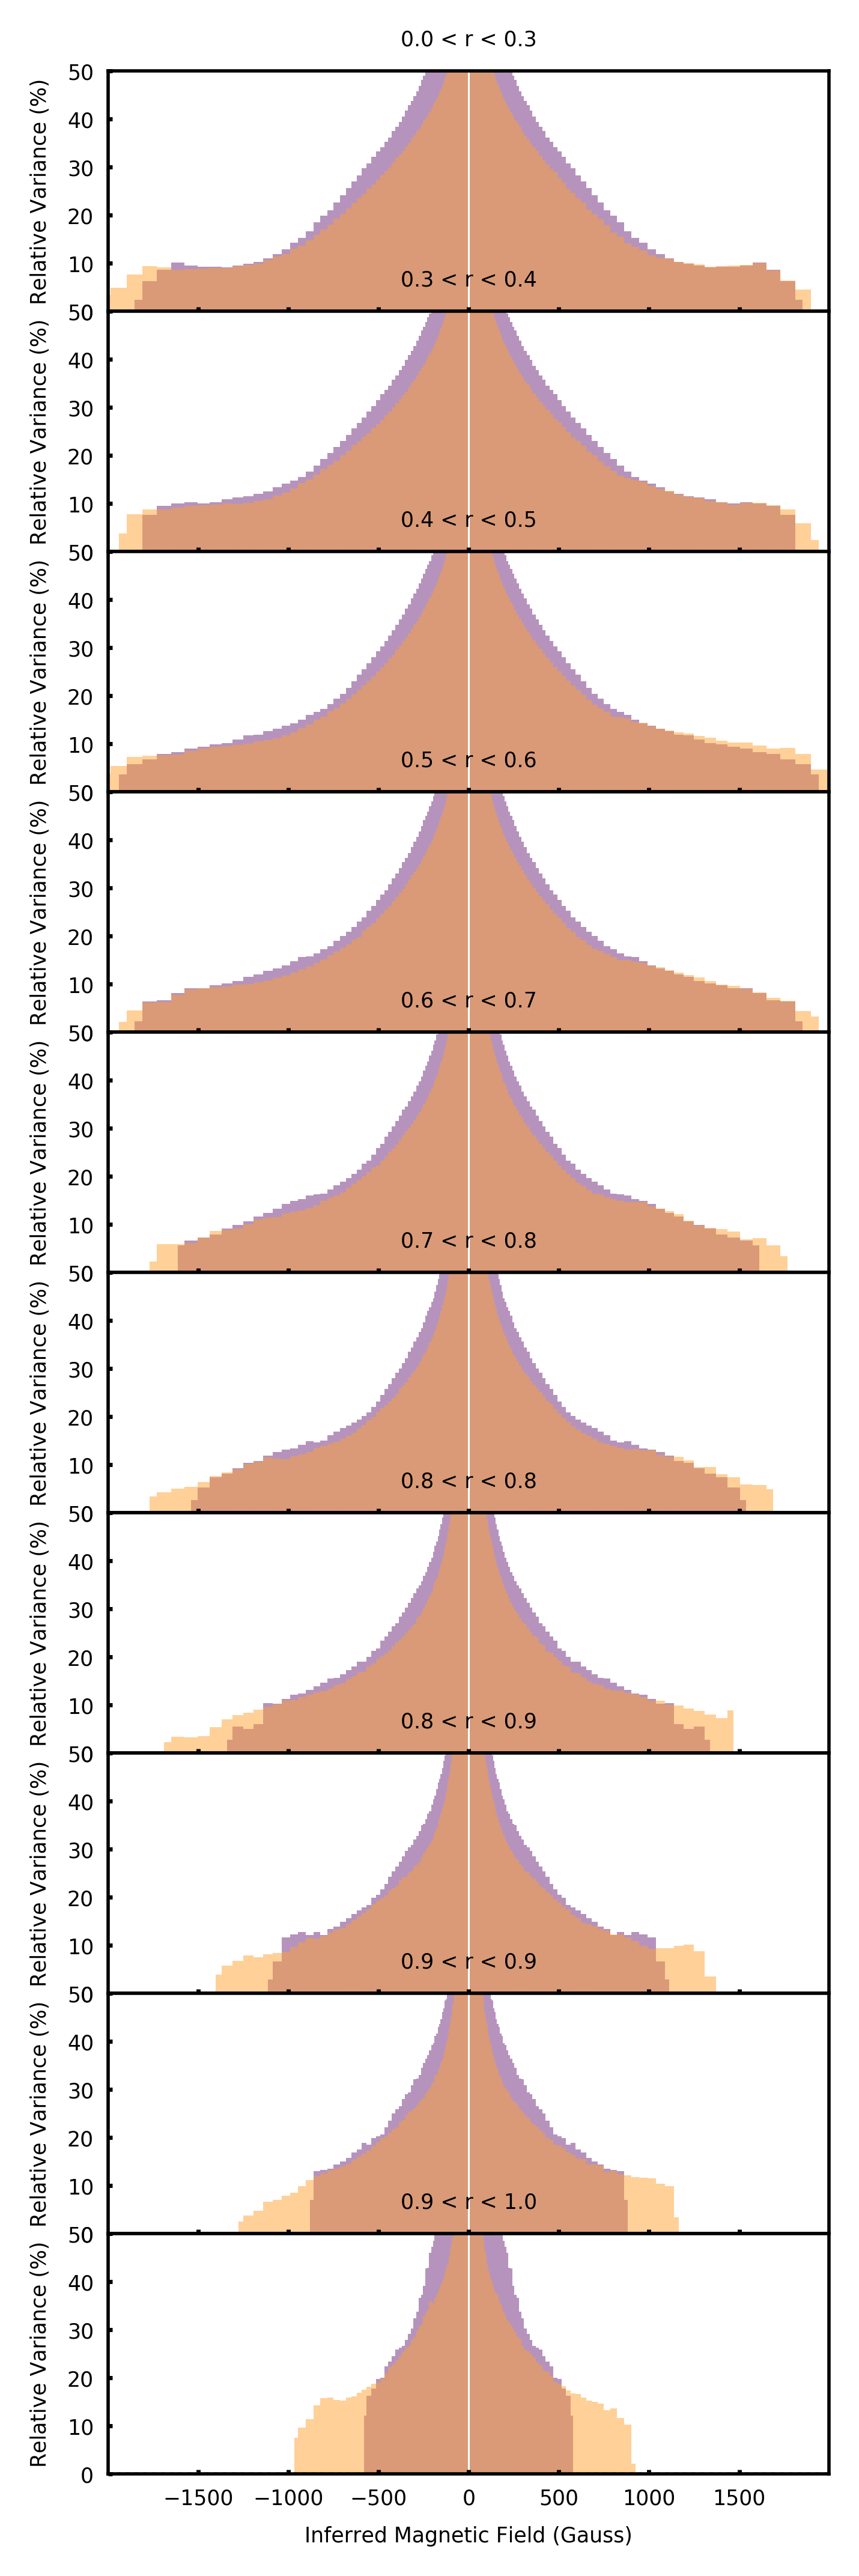

In [41]:


ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

for i in np.arange(0,10):
    
    blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to = hist2_to_load[:,:,i]

    blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti = hist2_ti_load[:,:,i]
    
    
    bins = create_hist_bins()
    centers = (bins[1:]+bins[0:-1])/2
    widths = (bins[1:]-bins[0:-1])

    noise = 5

    hist2_to[np.abs(centers)<noise, :] = 0
    hist2_to[:, np.abs(centers)<noise] = 0
    hist2_ti[np.abs(centers)<noise, :] = 0
    hist2_ti[:, np.abs(centers)<noise] = 0


    min_no_samples = 20

    hist2_to[hist2_to<min_no_samples] = 0
    hist2_ti[hist2_ti<min_no_samples] = 0
    
    norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
    norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

    norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
    norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)
    
    expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
    # ax3.plot(centers,(expected-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.7)
    # Removing entries with few samples

    varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    varianceML = np.sqrt(varianceML)    

#     varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)    

    
    ax4 = fig.add_axes([ppadh, ppadv-ppxy/3*i, ppxx, ppxy/3])

    expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    # ax4.plot(centers/Cal,(expected-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.5)

    variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    variance = np.sqrt(variance)

    # ax4.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    # ax4.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

    # ax4.fill_between(centers/Cal, ((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, ((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, color='#ffa232', alpha=0.3, ec='None')


    # ax3.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    # ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)

    # ax3.plot(centers/Cal,variance/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    ax4.fill_between(centers/Cal,np.abs(variance/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
    # ax3.plot(centers/Cal,np.abs((expected-centers)), linestyle='--', label=label, color='b', linewidth=0.2)
    # ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    ax4.fill_between(centers/Cal,np.abs(varianceML/centers*res_scale), label=label, fc='#ffa232', ec='None', alpha=0.5, step='mid')
    # ax4.plot(centers/Cal,np.abs(variance), linestyle='-', label=label, color='b', linewidth=0.2)
    # ax4.plot(centers,np.abs(varianceML), linestyle='-', label=label, color='#ffa232', linewidth=0.2)


    ax4.set_ylabel('Relative Variance (%)', fontsize=5)
    ax4.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
    ax4.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

    ax4.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
    # ax4.plot([-15, -15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
    # ax4.plot([15, 15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
    # ax4.yaxis.tick_right()
    # ax4.yaxis.set_label_position("right")
    ax4.set_xlim([-ax_lim, ax_lim])
    ax4.set_ylim([0, 50])
    # ax4.set_ylim([0, 200])
    ax4.set_title(str(np.round(binsr[i],1)) + ' < r < ' + str(np.round(binsr[i+1],1)), fontsize=5)

(0.0, 0.0, 0.5, 1.0)
(0.0, 0.0, 0.9545454545454546, 1.0)
(0.0, 0.3, 1.0, 1.0)
(0.0, 0.7000000000000002, 1.0, 1.0)
(0.16129032258064513, 1.0, 0.8064516129032259, 1.0)
(0.4838709677419354, 1.0, 0.4838709677419355, 1.0)
(0.806451612903226, 1.0, 0.1612903225806449, 1.0)
(1.0, 0.7777777777777775, 0.0, 1.0)
(1.0, 0.40740740740740733, 0.0, 1.0)
(0.9545454545454547, 0.03703703703703687, 0.0, 1.0)


(0, 50)

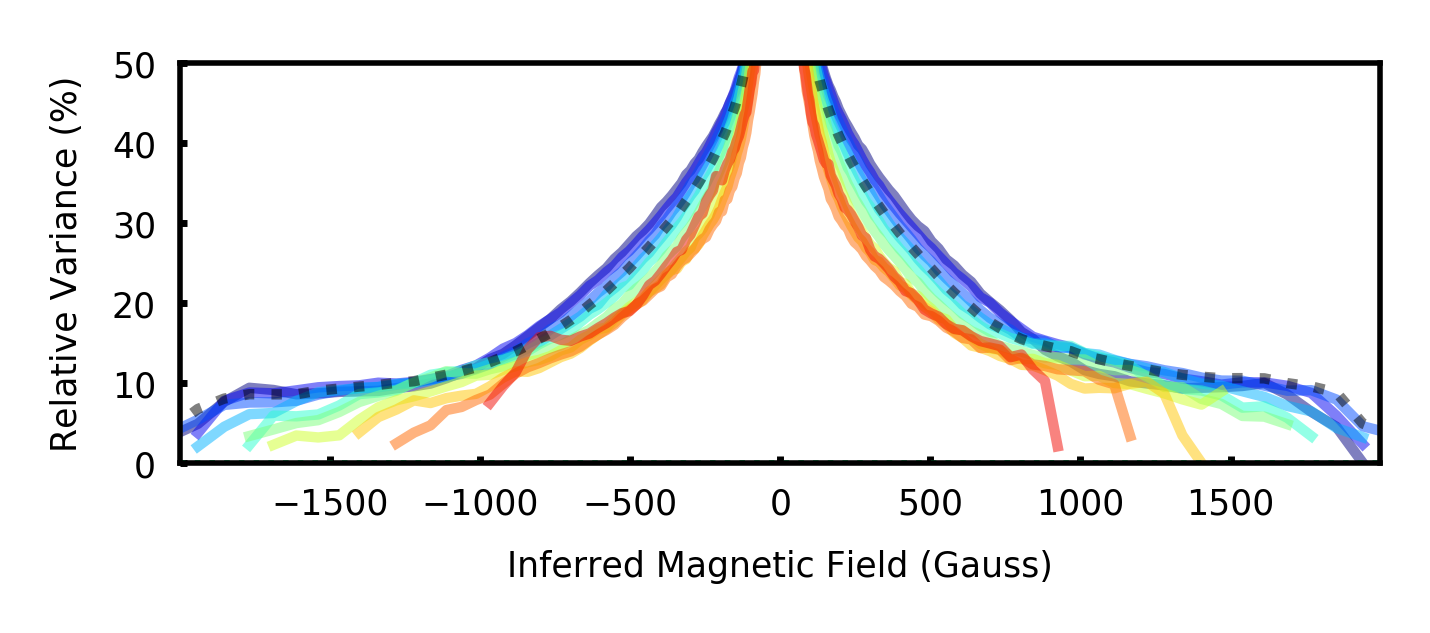

In [42]:


ftsz = 4

cmax = 700

ax_lim = 1999
res_lim = 20
res_scale = 100

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

ax4 = fig.add_axes([ppadh, ppadv, ppxx, ppxy/3])


colormap = cm.get_cmap('jet', 11)


for i in np.arange(0,10):
    print(colormap(i/11))
    
    blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
    hist2_to = hist2_to_load[:,:,i]

    blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
    file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
    hist2_ti = hist2_ti_load[:,:,i]
    
    
    bins = create_hist_bins()
    centers = (bins[1:]+bins[0:-1])/2
    widths = (bins[1:]-bins[0:-1])

    noise = 5

    hist2_to[np.abs(centers)<noise, :] = 0
    hist2_to[:, np.abs(centers)<noise] = 0
    hist2_ti[np.abs(centers)<noise, :] = 0
    hist2_ti[:, np.abs(centers)<noise] = 0


    min_no_samples = 20

    hist2_to[hist2_to<min_no_samples] = 0
    hist2_ti[hist2_ti<min_no_samples] = 0
    
    norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
    norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

    norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
    norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)
    
    expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
    # ax3.plot(centers,(expected-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.7)
    # Removing entries with few samples

    varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
    varianceML = np.sqrt(varianceML)    
    
    


    expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    # ax4.plot(centers/Cal,(expected-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.5)

    variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
    variance = np.sqrt(variance)

    # ax4.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    # ax4.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

    # ax4.fill_between(centers/Cal, ((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, ((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, color='#ffa232', alpha=0.3, ec='None')


    # ax3.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    # ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)

    # ax3.plot(centers/Cal,variance/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
#     ax4.fill_between(centers/Cal,np.abs(variance/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
    # ax3.plot(centers/Cal,np.abs((expected-centers)), linestyle='--', label=label, color='b', linewidth=0.2)
    # ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
    ax4.plot(centers/Cal,np.abs(varianceML/centers*res_scale), alpha=0.5, color=colormap(i/10))
    # ax4.plot(centers/Cal,np.abs(variance), linestyle='-', label=label, color='b', linewidth=0.2)
    # ax4.plot(centers,np.abs(varianceML), linestyle='-', label=label, color='#ffa232', linewidth=0.2)
    
    
    
    
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_to_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_to = np.sum(hist2_to_load, axis=2)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)


bins = create_hist_bins()
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

noise = 5

hist2_to[np.abs(centers)<noise, :] = 0
hist2_to[:, np.abs(centers)<noise] = 0
hist2_ti[np.abs(centers)<noise, :] = 0
hist2_ti[:, np.abs(centers)<noise] = 0


min_no_samples = 20

hist2_to[hist2_to<min_no_samples] = 0
hist2_ti[hist2_ti<min_no_samples] = 0

norm_to=hist2_to/(xp*y)/np.sum(hist2_to)
norm_ti=hist2_ti/(xp*y)/np.sum(hist2_ti)

norm_toy = hist2_to/x/np.repeat(np.sum(hist2_to, axis=0)[None, :], norm_to.shape[0], axis=0)
norm_tiy = hist2_ti/x/np.repeat(np.sum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)

expected = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*np.repeat(centers[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
expected[np.nansum(hist2_to, axis=1)<min_no_samples] = np.nan
# ax3.plot(centers,(expected-centers)/np.abs(centers)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.7)
# Removing entries with few samples

varianceML = np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*(np.repeat(centers[:,None],norm_to.shape[0],axis=1) - np.repeat(expected[None],norm_to.shape[0],axis=0))**2*norm_to, axis=0)/np.nansum(np.repeat(widths[:,None],norm_to.shape[0],axis=1)*norm_to, axis=0)
varianceML = np.sqrt(varianceML)    




expected = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
# ax4.plot(centers/Cal,(expected-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.5)

variance = np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti.shape[0],axis=1) - np.repeat(expected[None],norm_ti.shape[0],axis=0))**2*norm_ti, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti.shape[0],axis=1)*norm_ti, axis=0)
variance = np.sqrt(variance)

# ax4.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)
# ax4.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='#ffa232', linewidth=0.2)

# ax4.fill_between(centers/Cal, ((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, ((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, color='#ffa232', alpha=0.3, ec='None')


# ax3.plot(centers/Cal,((expected-variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
# ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)

# ax3.plot(centers/Cal,variance/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
#     ax4.fill_between(centers/Cal,np.abs(variance/centers/Cal*res_scale), label=label, fc=Clr[2], ec='None', alpha=0.5, step='mid')
# ax3.plot(centers/Cal,np.abs((expected-centers)), linestyle='--', label=label, color='b', linewidth=0.2)
# ax3.plot(centers/Cal,((expected+variance)-centers/Cal)/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color='b', linewidth=0.2)
ax4.plot(centers/Cal,np.abs(varianceML/centers*res_scale), alpha=0.5, color='k', ls=':')
# ax4.plot(centers/Cal,np.abs(variance), linestyle='-', label=label, color='b', linewidth=0.2)
# ax4.plot(centers,np.abs(varianceML), linestyle='-', label=label, color='#ffa232', linewidth=0.2)    


ax4.set_ylabel('Relative Variance (%)', fontsize=5)
ax4.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=5)
ax4.tick_params(labelsize=5, direction='in', axis='both', which='major', length=1, width=1)

ax4.plot([-ax_lim, ax_lim], [0, 0], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.plot([-15, -15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.plot([15, 15], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# ax4.yaxis.tick_right()
# ax4.yaxis.set_label_position("right")
ax4.set_xlim([-ax_lim, ax_lim])
ax4.set_ylim([0, 50])
    # ax4.set_ylim([0, 200])
#     ax4.set_title(str(np.round(binsr[i],1)) + ' < r < ' + str(np.round(binsr[i+1],1)), fontsize=5)